<a href="https://colab.research.google.com/github/MaiMejia/ML-Projects/blob/main/Predicting_Subscription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <b> 📘 ML Solutions - Predicting Customer Subscriptions</b>
<a id='top'></a>

#### <b>📑 Table of Contents</b>
1.  <a href="#Context">Context</a>
2.  <a href="#Previewing the Dataset">Previewing the Dataset</a>
1.  <a href="#Exploratory Data Analysis">Exploratory Data Analysis</a>
  <br><a href="#a) Univariate"> a) Univariate</a>
  <br><a href="#b) Multivariate"> b) Multivariate</a>
1. <a href="#Data Preprocessing">Data Preprocessing</a>
2.  <a href="#Model Building">Model Building</a>
    <br><a href="#a) XGBoost: Initial Model"> a) XGBoost: Initial Model</a>
    <br><a href="#b) Hyperparameter Tuning with GridSearchCV"> b) Hyperparameter Tuning with GridSearchCV</a>
    <br><a href="#c) Final Model"> c) Final Model</a>
    <br><a href="#d) Feature Engineering"> d) Feature Engineering</a>
2.  <a href="#Model Diagnostic and Evaluation">Model Diagnostic and Evaluation</a>
    <br><a href="#a) Plotting Loss Curves - XGBoost Model"> a) Plotting Loss Curves - XGBoost Model</a>
    <br><a href="#b) Classification Report and Confusion Matrix"> b) Classification Report and Confusion Matrix</a>
    <br><a href="#c) Diagnostic Charts: y-True, y-Predicted, vs. X variables"> c) Diagnostic Charts: y-True, y-Predicted, vs. X variables</a>
1. <a href="#Saving Predicted Values"> Saving Predicted Values</a>
1. <a href="#Analysis: Customer Segmentation">Analysis: Customer Segmentation</a>
<br><a href="#Final Notes">Final Notes</a>

<a name="Context"></a>
#### <b> 1. Context</b>                                                     
A small startup focusing mainly on providing machine learning solutions in the European banking market. We work on a variety of problems including fraud detection, sentiment classification and customer intention prediction and classification.<br>

We are interested in developing a robust machine learning system that leverages information coming from call center data. Ultimately, we are looking for ways to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal we are working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for our clients to make informed decisions. <br>

**Goal:** Predict if the customer will subscribe (yes/no) to a term deposit (variable y).<br>
</p>

<p style="font-size:14px; line-height:1.5; margin-top:0px; margin-bottom:4px;">
<b>Data</b> <br>
The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns. <br>

<b>Attributes</b>  <br>
**age:** age of customer (numeric) <br>
**job:** type of job (categorical) <br>
**marital:** marital status (categorical) <br>
**education** (categorical) <br>
**default:** has credit in default? (binary) <br>
**balance:** average yearly balance, in euros (numeric) <br>
**housing:** has a housing loan? (binary) <br>
**loan:** has a personal loan? (binary) <br>
**contact:** contact communication type (categorical) <br>
**day:** last contact day of the month (numeric) <br>
**month:** last contact month of year (categorical) <br>
**duration:** last contact duration, in seconds (numeric) <br>
**campaign:** number of contacts performed during this campaign and for this client (numeric, includes last contact) <br>

**Output (desired target):** <br>
**y** - has the client subscribed to a term deposit? (binary)
</p>

In [ ]:
#Installing libraries
# %pip install hyperopt xgboost seaborn gdown smote imbalanced-learn imblearn[all] scikit-learn==1.5.0 catboost lightgbm
# %pip install --upgrade scikit-learn
# %pip install --upgrade imbalanced-learn
# %pip install --upgrade imblearn
# %pip install --upgrade hyperopt

In [ ]:
import google.colab
google.colab.drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing libraries
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, display
import sys
import io
import base64
import importlib
import plotly.express as px

# Model building libraries
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold, cross_val_predict, learning_curve
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, make_scorer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel, f_classif
from sklearn.pipeline import Pipeline

# Imbalanced data handling libraries
from imblearn.pipeline import Pipeline as ImbPipeline # To integrate SMOTE with the pipeline

import warnings
warnings.filterwarnings('ignore')

<p style="font-size:14px; line-height:1.5; margin-top:0px; margin-bottom:4px;">
<b>Importing helper modules and data</b> </p>

In [ ]:
# Add path to sys.path if it's not already present
path_to_add = '/content/drive/MyDrive/Colab Notebooks/'
if path_to_add not in sys.path:
    sys.path.append(path_to_add)

# Clear the module cache (in case it's cached or outdated)
if 'data_helper' in sys.modules:
    del sys.modules['data_helper']

if 'helper_module' in sys.modules:
    del sys.modules['helper_module']

# Import the modules
import data_helper
import helper_module
importlib.reload(data_helper)
importlib.reload(helper_module)

# Define the file ID and destination for downloading
file_id = "1wktqiQSaZoJk8iL3i0UWZkfgGyUjB2ME"
destination = "/content/drive/MyDrive/Colab Notebooks/dataset.csv"

# Download the data using the function
df = data_helper.download_file_from_google_drive(file_id, destination)

# Check the first few rows of the DataFrame
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


<a name="Previewing the Dataset"></a>
#### <b>2. Previewing the Dataset</b>
<p style="font-size:14px; line-height:1.5; margin-top:0px; margin-bottom:4px;">Load and view the raw data to understand its structure.</p>

In [ ]:
df.shape

(40000, 14)

In [ ]:
df.info() # Check data types and null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [ ]:
# Describing numerical features
df.describe().round(0)  # Review the summary statistics to get a better understanding of the dataset.

,age,balance,day,duration,campaign
count,40000.0,40000.0,40000.0,40000.0,40000.0
mean,41.0,1274.0,16.0,255.0,3.0
std,10.0,2904.0,8.0,259.0,3.0
min,19.0,-8019.0,1.0,0.0,1.0
25%,33.0,54.0,8.0,100.0,1.0
50%,39.0,407.0,17.0,175.0,2.0
75%,48.0,1319.0,21.0,313.0,3.0
max,95.0,102127.0,31.0,4918.0,63.0


In [ ]:
df.isnull().sum()     # Verify if the dataset contains missing values.

,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


<p style="font-size:14px; line-height:1.5; margin-top:0px; margin-bottom:4px;"><b>Observations</b>

*  The dataset contains 17 columns (features) and 39,999 records on each column.
*  There are no null/missing values.
* The target variable (Y) contains yes/no data.
<br><b>Note:</b> For EDA, data remains unchanged for readability; binary encoding is applied to binary categorical variables afterward.</p>

<a name="Exploratory Data Analysis"></a>
#### <b>3. Exploratory Data Analysis</b>
<p style="font-size:14px; line-height:1.5; margin-top:0px; margin-bottom:4px;">Perform initial analysis and visualization of key variables.</p>

<a name="a) Univariate"></a>
##### <b>3.a. Univariate</b>
<p style="font-size:14px; line-height:1.5; margin-top:0px; margin-bottom:4px;">Analyze individual variables using plots.</p>

In [ ]:
# Counting Y labels to see if hey are balanced
df['y'].value_counts()/sum(df['y'].value_counts())  # Check the distribution of the target variable

,count
y,
no,0.9276
yes,0.0724



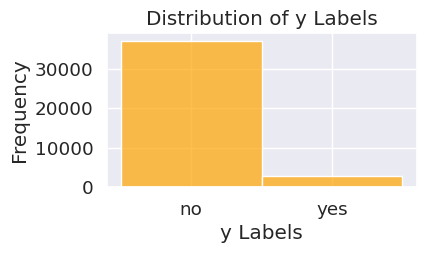

In [ ]:
# Calling the helper module to plot the distribution of the target variable
helper_module.plot_target_dist(df)  # To visualize the distribution of 'y'

<p style="font-size:14px; line-height:1.5; margin-top:0px; margin-bottom:4px;"><b>Observations</b>
<p style="font-size:14px; line-height:1.5; margin-top:0px; margin-bottom:4px;">The label no is unbalanced with 92% of the labels.</p>


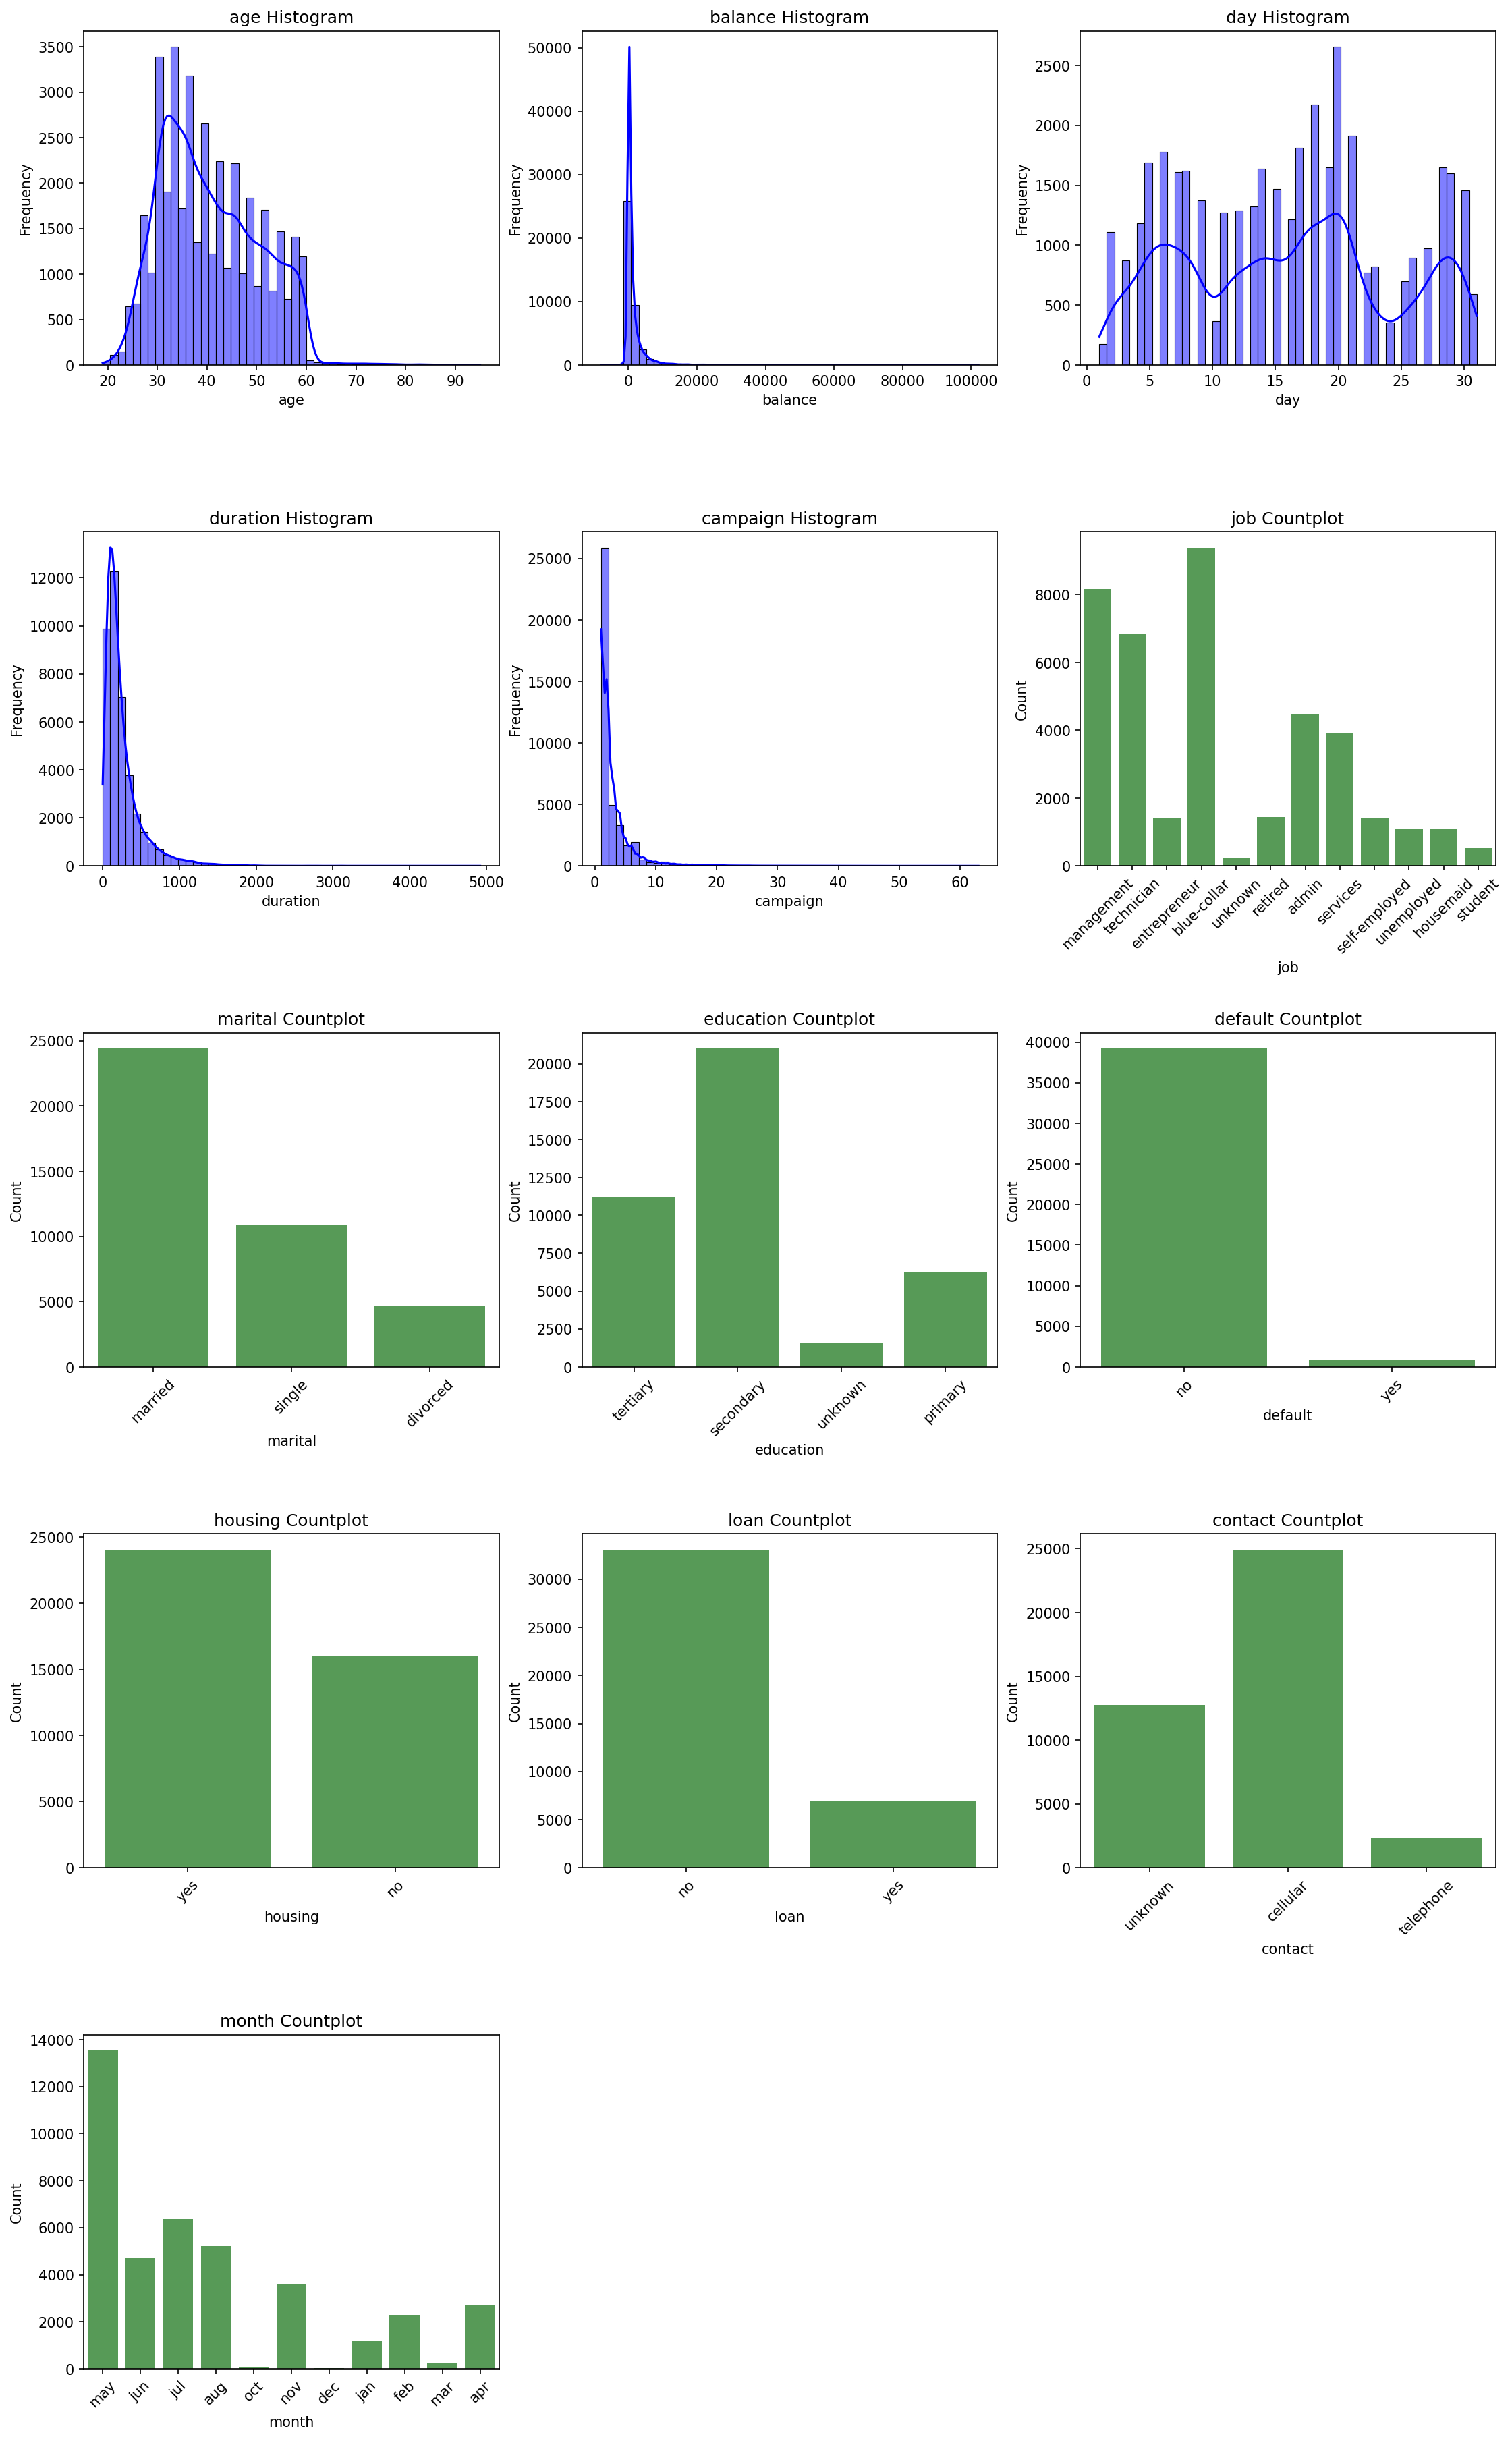

In [ ]:
# Plotting the distribution of each variable
univariate = helper_module.plot_univariate_dist(df)

<p style="font-size:14px; line-height:1.5; margin-top:0px; margin-bottom:4px;"><b>Analyzing skewed numeric variables</b>

In [ ]:
# Age
fig = px.histogram(df,x="age", nbins=200)
fig.show()

In [ ]:
# Balance
fig = px.histogram(df, x="balance", nbins=500)
fig.show()

<p style="font-size:14px; line-height:1.5; margin-top:0px; margin-bottom:4px;"><b>Trasnforming the duration variable from second to minutes</b>

In [ ]:
# Duration: This metric is measured in seconds. For an easy understanding of its impact, It is better to transform this variable to minutes.
df['duration_min'] = df['duration'] / 60
df['duration_min'] = df['duration_min'].round(0)
df['duration_min'] = df['duration_min'].astype(int)
df = df.drop('duration', axis=1)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,y,duration_min
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,no,4
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,no,3
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,no,1
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,no,2
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,no,3


In [ ]:
# Duration (minutes)
fig = px.histogram(df, x="duration_min", nbins=200)
fig.show()

In [ ]:
# Campaign
fig = px.histogram(df, x="campaign", nbins=200)
fig.show()


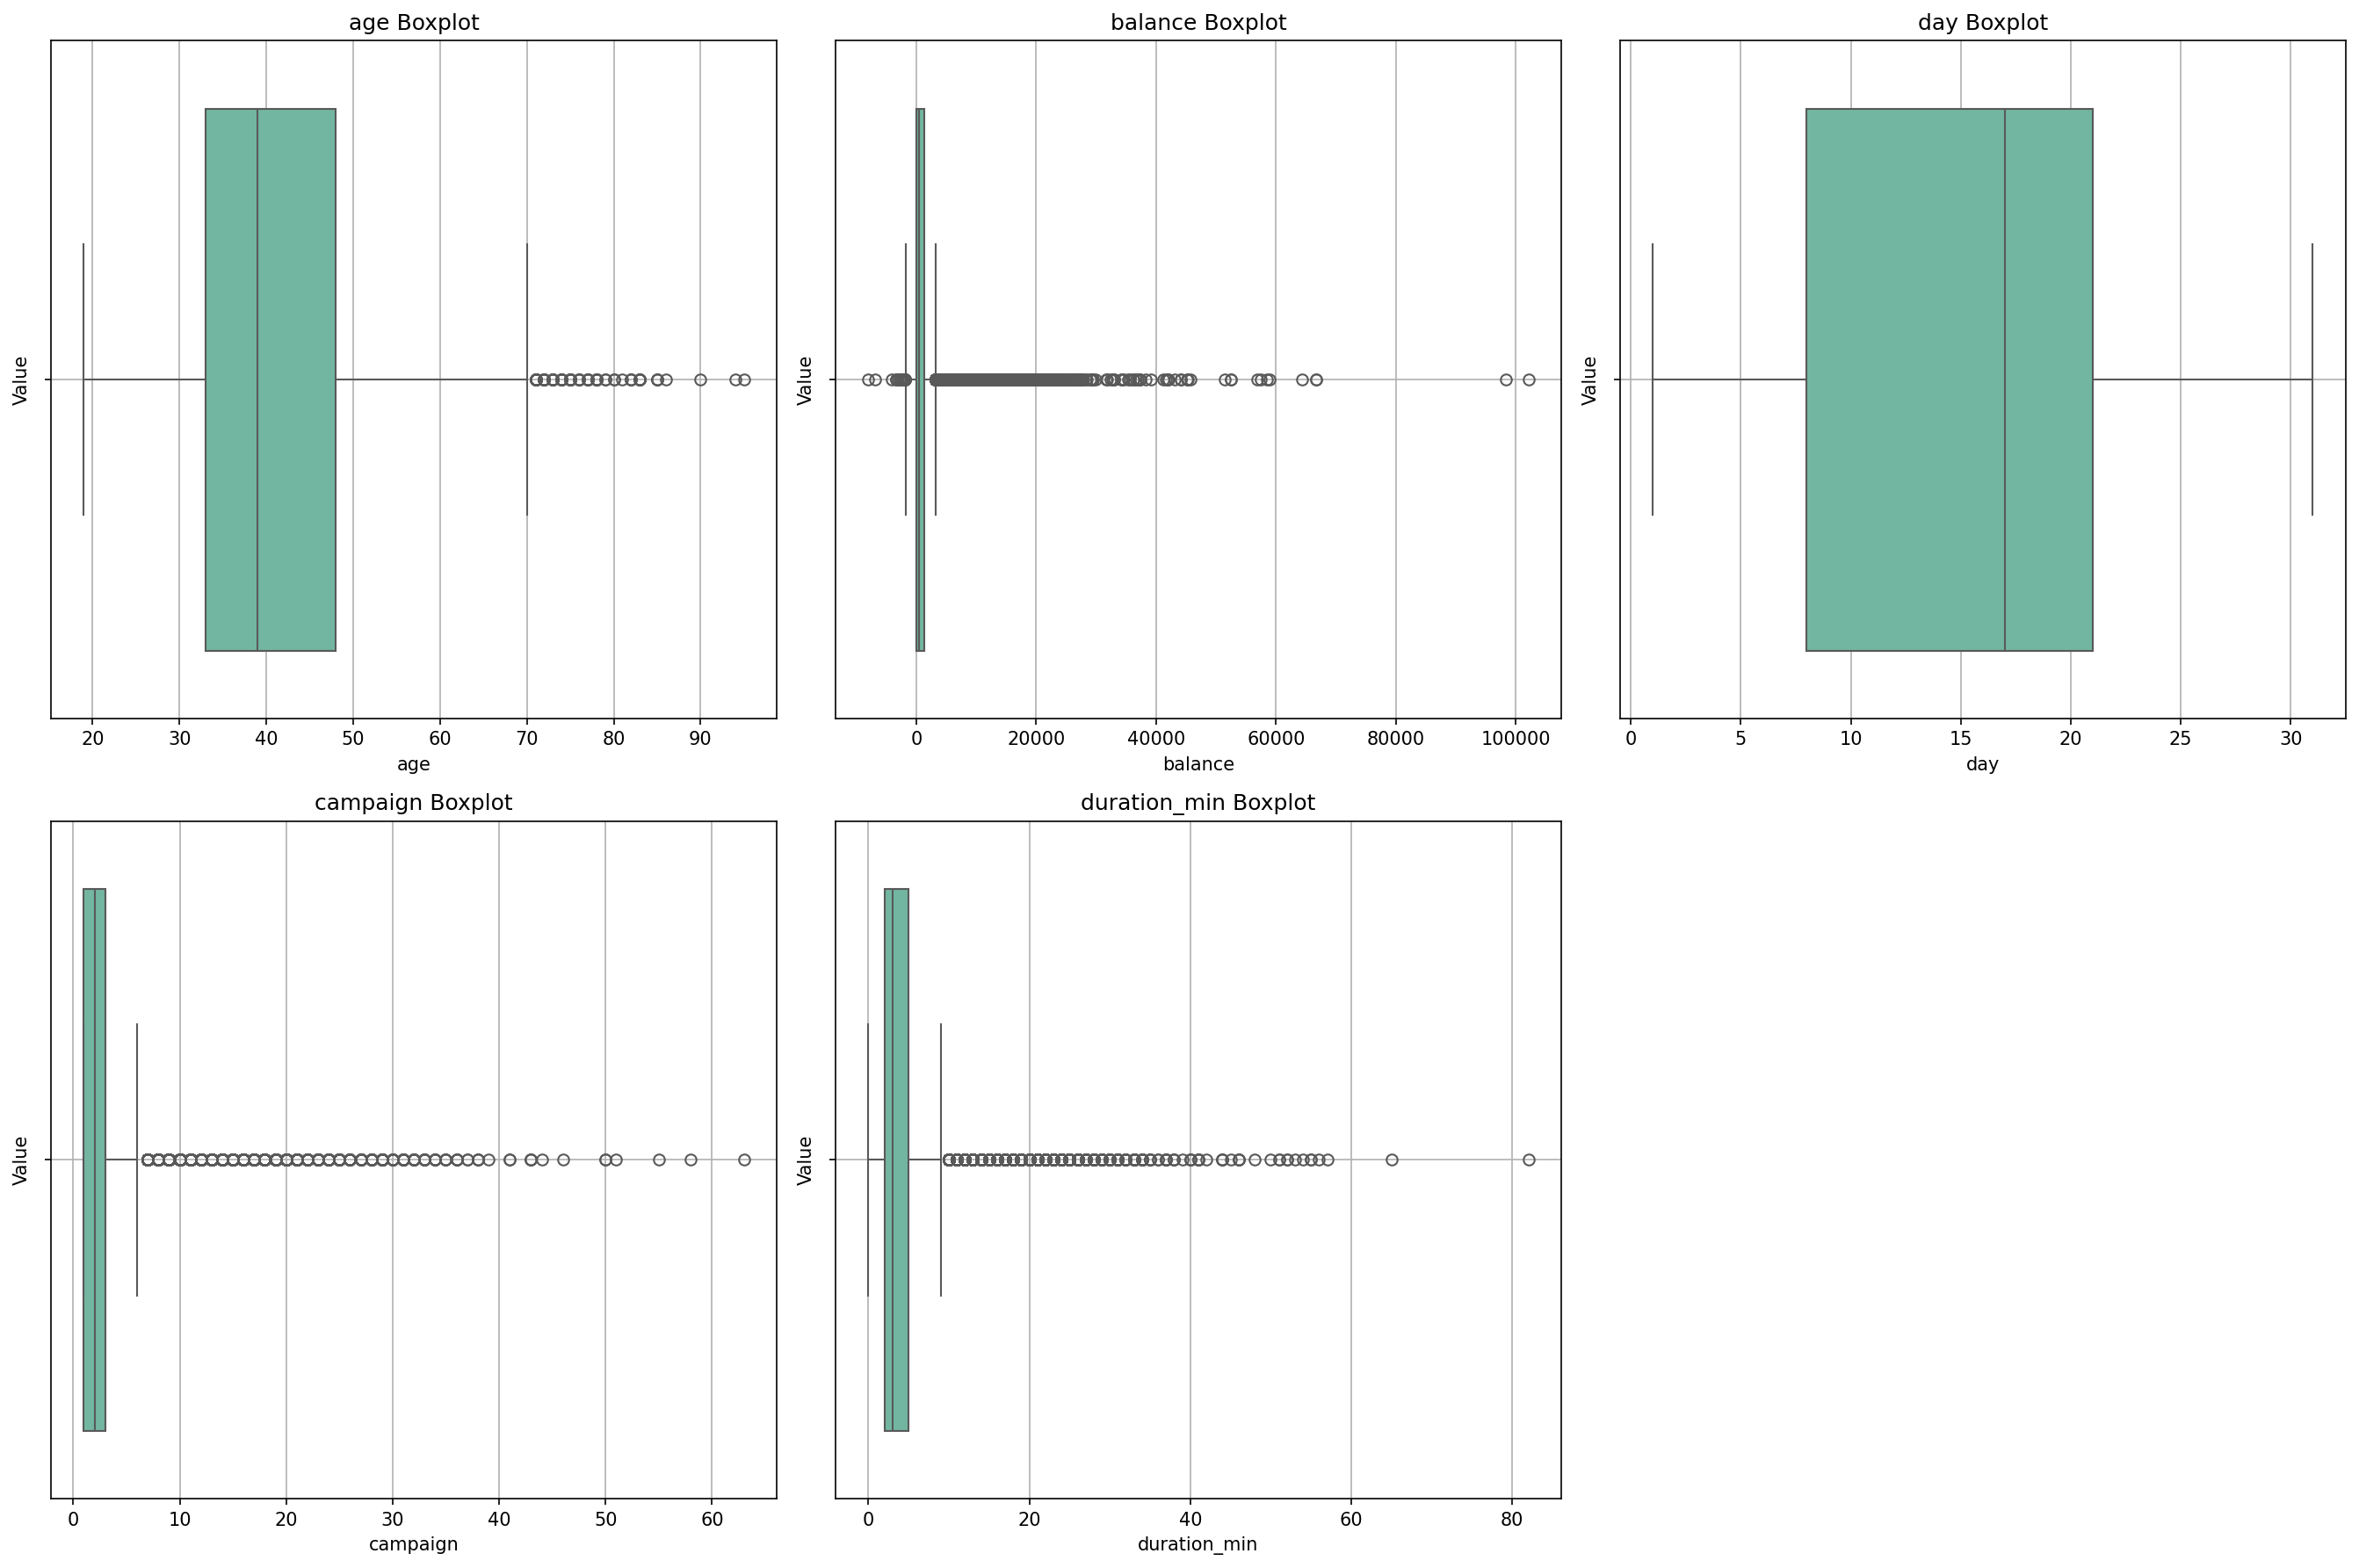

In [ ]:
### ----- This is used to refresh the module when i add new functions
import importlib
import helper_module
# importlib.reload(helper_module)

# Calling the module ti plot the distribution if the target variable
boxplots = helper_module.plot_boxplots(df)

<h4 style="font-size:18px; font-weight:bold; margin-bottom:1px;"><b>Handling outliers</b></h4><p style="font-size:14px; line-height:1.5; margin-top:0px; margin-bottom:4px;">

In [ ]:
# Appliying the IQR method, so we dont discard any data points that might be relevant for the analysis
df = helper_module.cap_outliers(df)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,y,duration_min
0,58.0,management,married,tertiary,no,2143.0,yes,no,unknown,5,may,1,no,4.0
1,44.0,technician,single,secondary,no,29.0,yes,no,unknown,5,may,1,no,3.0
2,33.0,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,5,may,1,no,1.0
3,47.0,blue-collar,married,unknown,no,1506.0,yes,no,unknown,5,may,1,no,2.0
4,33.0,unknown,single,unknown,no,1.0,no,no,unknown,5,may,1,no,3.0



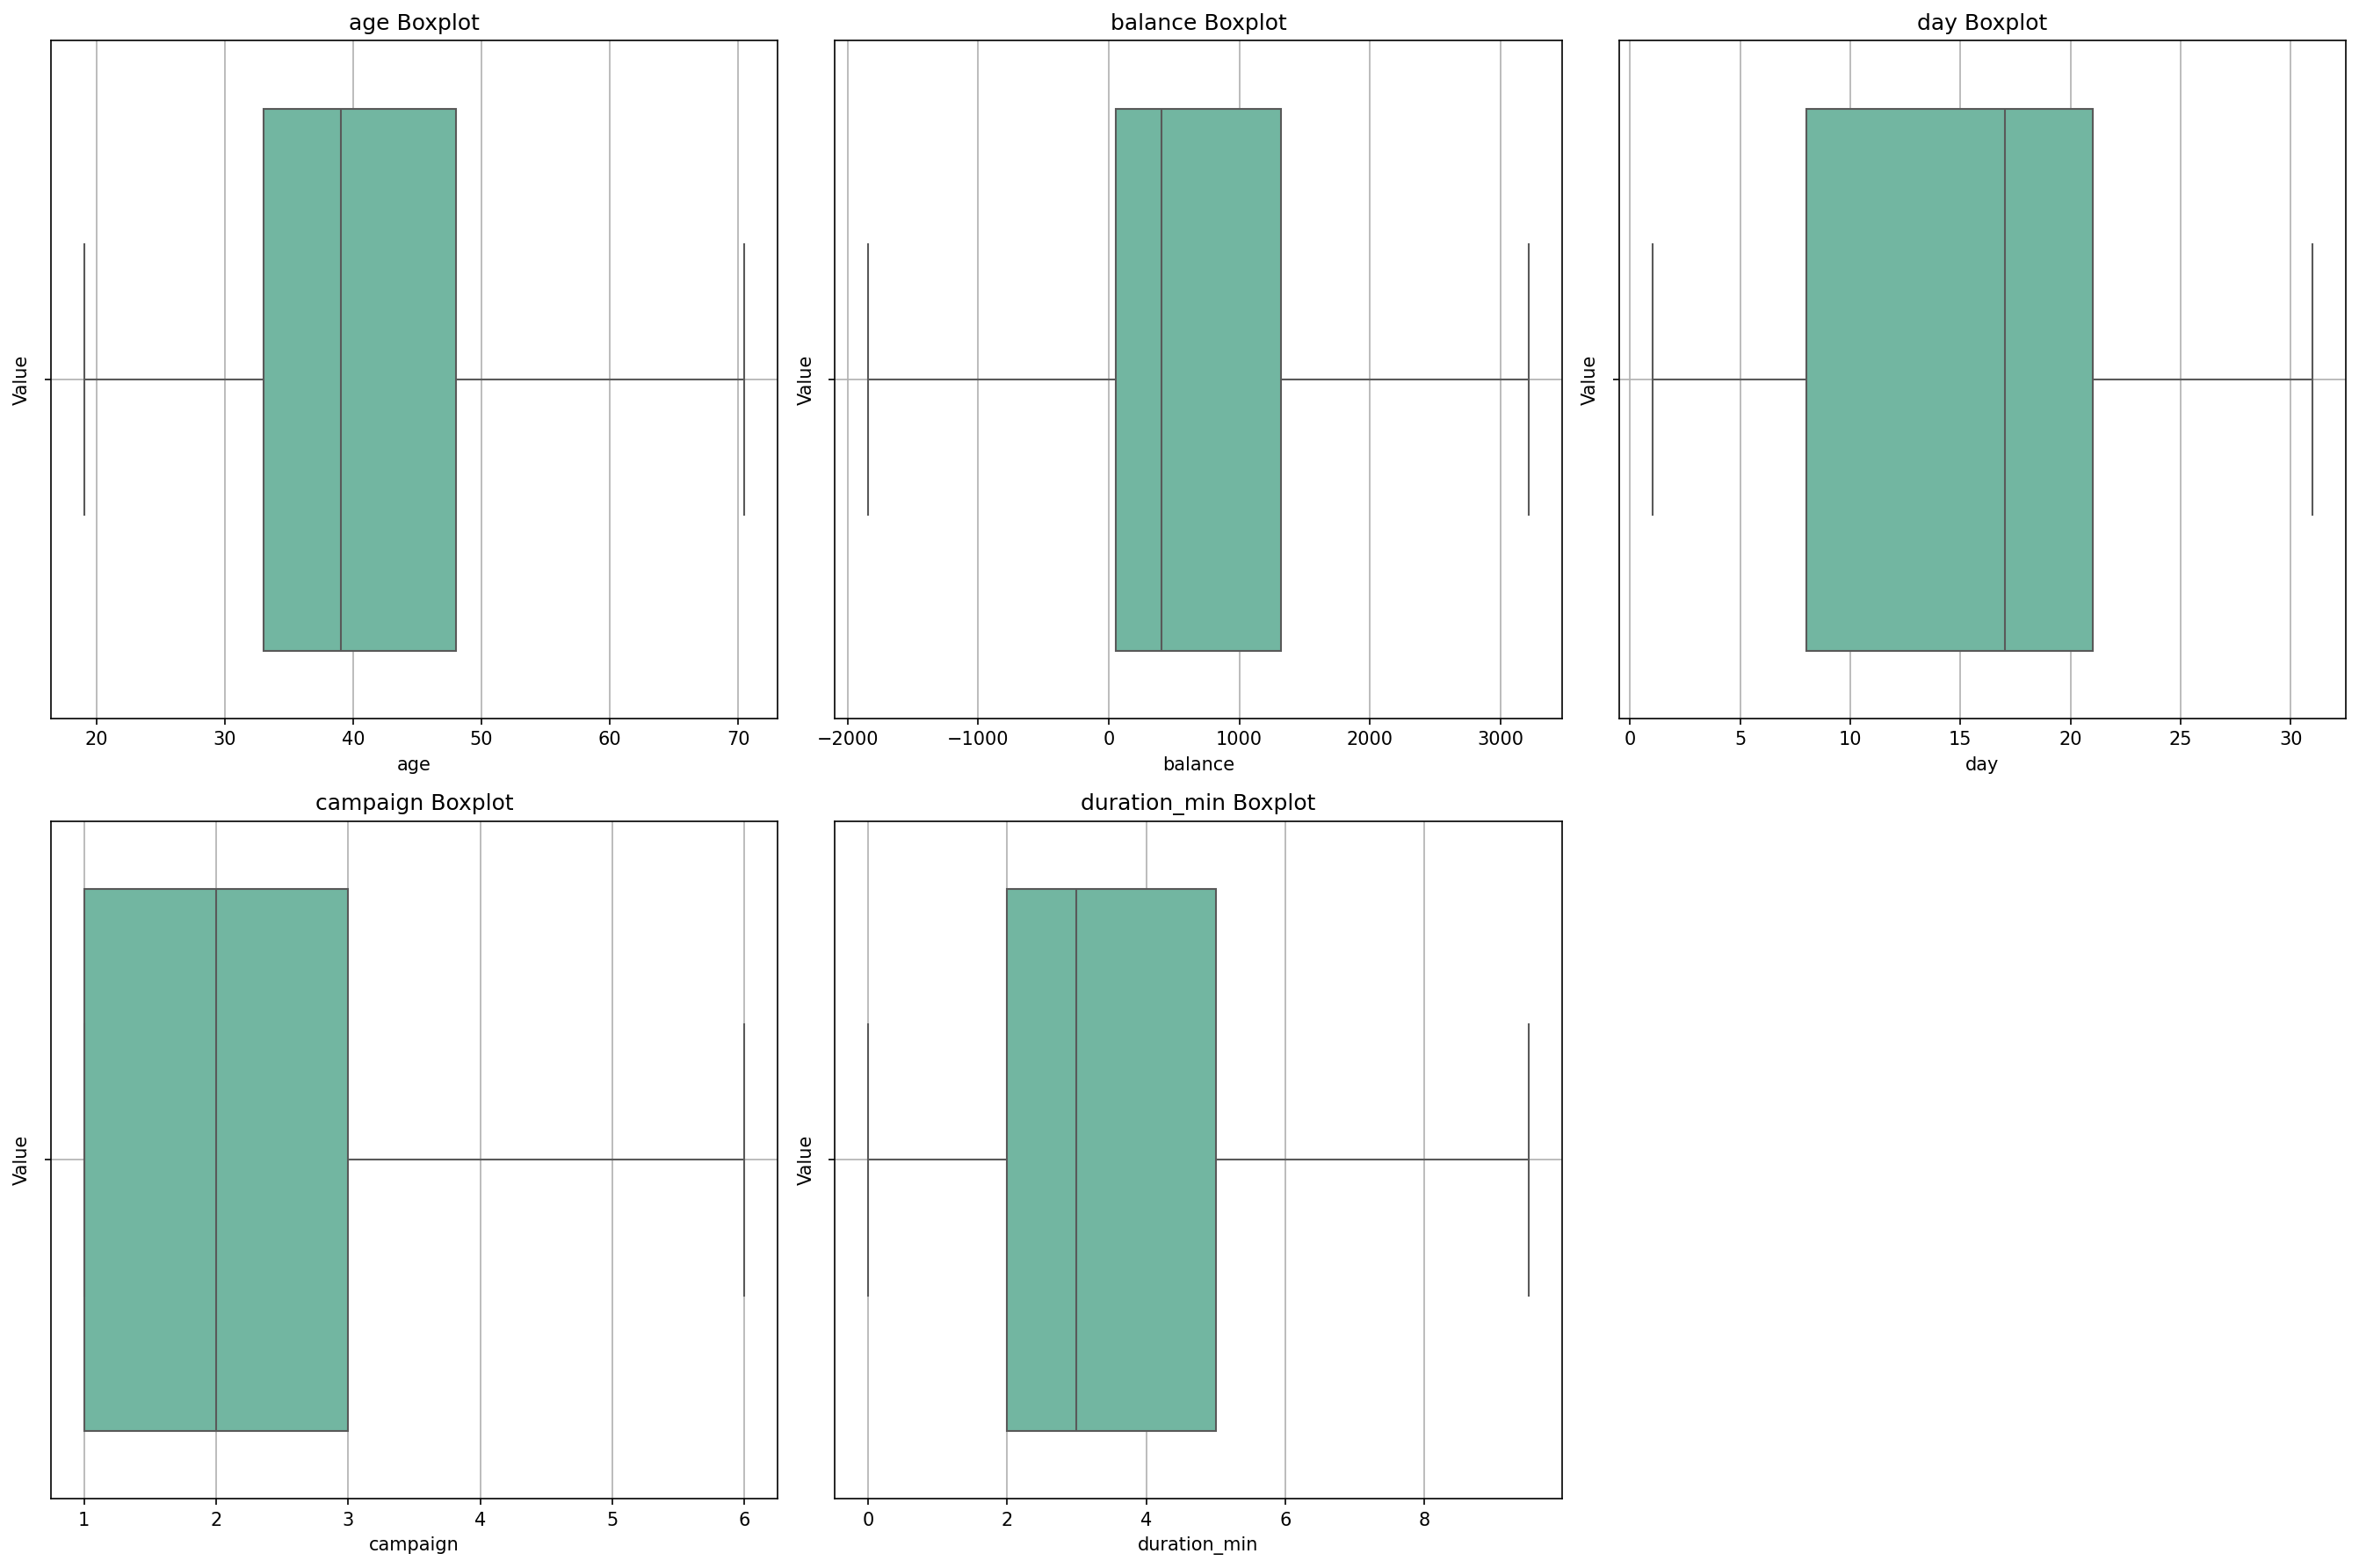

In [ ]:
boxplots_after = helper_module.plot_boxplots(df)

In [ ]:
### saving the dataset preprocessed
df.to_csv('/content/drive/MyDrive/Colab Notebooks/data_preprocessed.csv', index=False)

In [ ]:
### Plotting numeric variables only, after handling outliers
from plotly.subplots import make_subplots
import plotly.graph_objects as go

num = df.select_dtypes(include=['int64', 'float64'])
num_cols = num.columns.tolist()

fig = make_subplots(rows=3, cols=2, subplot_titles=num.columns[:6])

for i, col_name in enumerate(num_cols):
  row=i//2+1
  col=i%2+1

  histogram = go.Histogram(x=num[col_name], nbinsx=200, name=col)
  fig.add_trace(histogram, row=row, col=col)


fig.update_layout(height=1600, width=1600, showlegend=False)
fig.show()

  # px.histogram(num, x=col, nbins=50).show()

<p style="font-size:14px; line-height:1.5; margin-top:0px; margin-bottom:4px;"><b>Observations</b></p>
<ol style="font-size:14px; line-height:1.5; margin-top:0;">
  <li>The <b>target variable (y)</b> labels are imbalance 93% of labels are 'no' and 7% 'yes'. This can hurt model performance, because the model just predicte using the majority of classes. </li>
  <li>Most <b>numerical variables</b> exhibit a right-skewed distribution. A higher percentage of customer are between 30 and 40 years old, with a large proportion with an average yearly balance of 5K Euros or lower. </li>
  <li>While <b>categorical variables</b> show diverse distributions. The population is primarily employed in management, blue-collar, or technician roles, with most having completed secondary education, being married, owning a home, and not having any loans </li>
  <li>Some variables contained <b>outliers:</b> Age, Balance, Duration (last contact), and Campaign (number of contacts performed). Therefore, the IQR method was applied to cap outliers and do not remove relevant data.</li>
  </ol>

<a name="b) Multivariate"></a>
##### <b>3.b. Multivariate</b>
<p style="font-size:14px; line-height:1.5; margin-top:0px; margin-bottom:4px;">Explore relationships between multiple variables.</p>


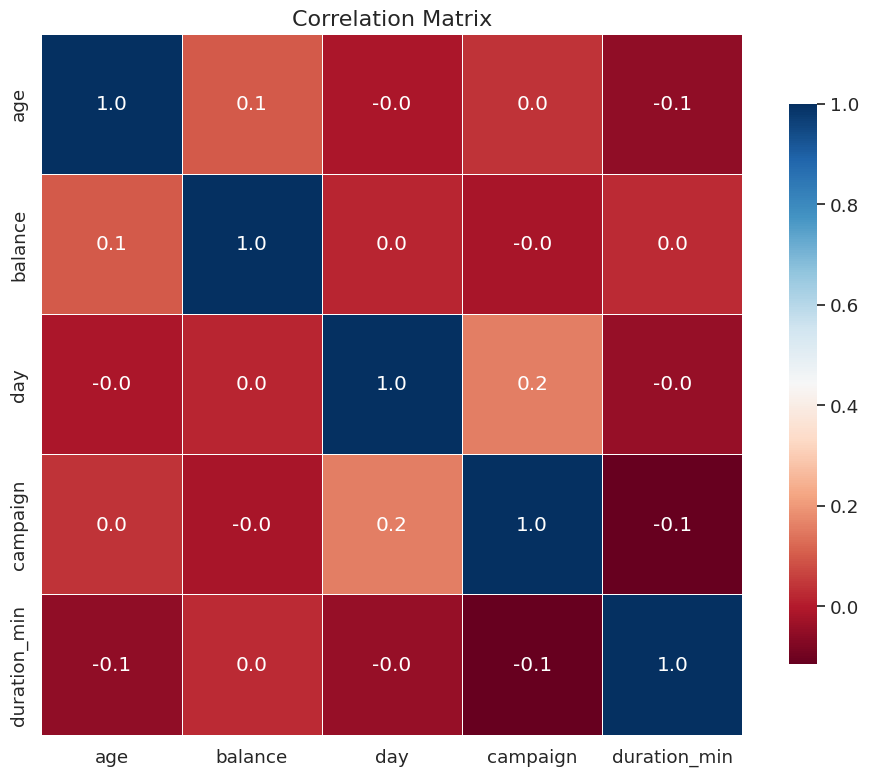

In [ ]:
# Separate features and target variable
helper_module.plot_corr_matrix(df)  # Plot correlation matrix

In [ ]:
anova = helper_module.anova_analysis(df)
anova
# print(anova_df.head(5))  # Display the first few rows of the ANOVA results

,Categorical Column,Numerical Column,F-statistic,p-value
0,job,age,623.076102,0.000000e+00
1,job,balance,30.949512,5.038343e-66
2,job,day,10.234876,5.963883e-19
3,job,campaign,11.266179,3.185378e-21
4,job,duration_min,5.040020,6.524730e-08
5,marital,age,4187.139241,0.000000e+00
6,marital,balance,33.935995,1.880509e-15
7,marital,day,0.619258,5.383486e-01
8,marital,campaign,40.311303,3.240743e-18
9,marital,duration_min,19.032236,5.474386e-09



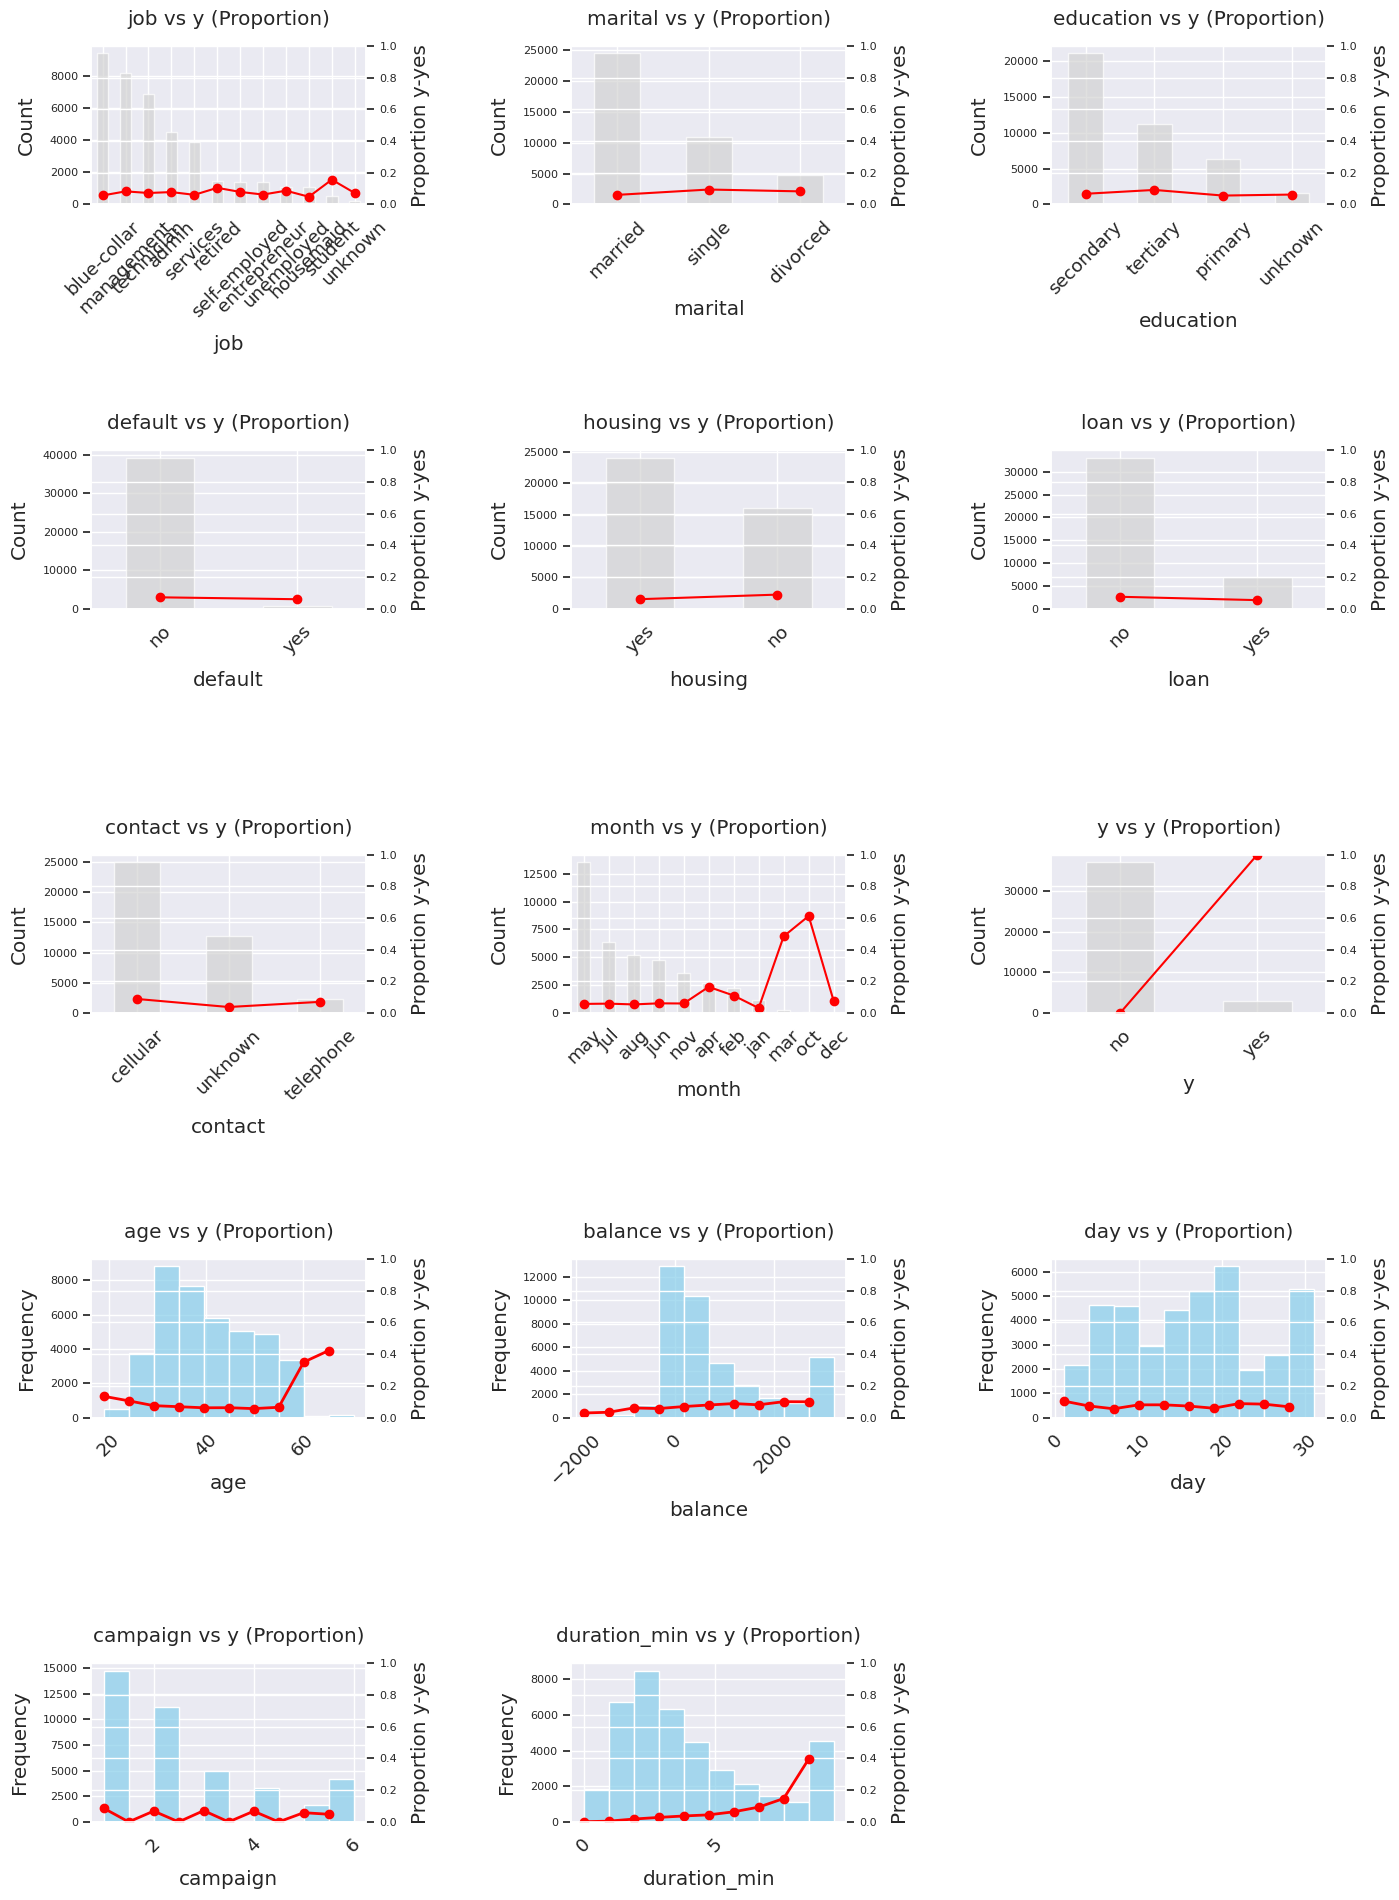

In [ ]:
X_cols = df.drop(columns=['y']).columns.tolist()
helper_module.plot_x_vs_y(df, df.columns.tolist(), 'y', positive_label='yes', n_cols=3, max_bins=10)

<h6 style="font-size:15px; font-weight:bold; margin-bottom:4px;"><b>Observations:</b></h6>
<ol style="font-size:14px; line-height:1.5; margin-top:0;">
  <li>The <b>Correlation Matrix</b> shows correlations close to zero, which means weak relationships across variables. </li>
  <li>A further analysis, <b>ANOVA (Analysis of Variance)</b> was performed to test whether there are statistically significant differences between the means of groups, numerical columns against categorical variables. And the <b>results</b> depicts an 80% of the pairs (num-cat) have a p-value ≤ 0.05, which suggests that there is a significant difference in the mean of numeric variables and the different categories. </li>
  <li>Finally, a <b>proportion-based chart</b> - target variable (Y) as a proportion - vs. numerical and categorical variables, confirms that the distribution of Y is skewed and requires to apply a technique to handle the umbalance of the labels. A few variables see high values for y-proportion, age, month, and duration.</li>
  </ol>

<a name="Data Preprocessing"></a>
#### <b>4. Data Preprocessing</b>
<p style="font-size:14px; line-height:1.5; margin-top:0px; margin-bottom:4px;">Using the helper module, the data is preprocessed</p>

In [ ]:
# # # --- Preprocessing ---

# X_final, y_final, preprocessor = helper_module.preprocessing_df(df)

# X_processed = preprocessor.fit_transform(X_final)

# # Split data: Train-Val & Train-test
# X_train_init, X_val, y_train_init, y_val = train_test_split(X_processed, y_final, test_size=0.3, random_state=42, stratify=y_final)
# X_train, x_test, y_train, y_test = train_test_split(X_train_init, y_train_init, test_size=0.2, random_state=42, stratify=y_train_init)

In [ ]:
import helper_module
importlib.reload(helper_module)

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_preprocessed.csv')
# Prepare data (no transforms yet)
X, y, column_info = helper_module.preprocessing_data(df)

# Split into train, val, test
X_train_raw, X_val, y_train_init, y_val = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
X_train_final, X_test, y_train_final, y_test = train_test_split(X_train_raw, y_train_init, stratify=y_train_init, test_size=0.2, random_state=42)

# ColumnTransformer (fit on train only)
preprocessor = ColumnTransformer(transformers=[
    ('num', 'passthrough', column_info['numerical']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), column_info['categorical'])
])

#Fit transformer only on training data
preprocessor.fit(X_train_raw)

# Transform splits
X_train_init = preprocessor.transform(X_train_raw)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

In [ ]:
## Data splits sizes:
print(f"Total samples: {X.shape[0]}")

print(f"Train: {X_train_init.shape[0]}")
print(f"Validation: {X_val.shape[0]}")
print(f"Test: {X_test.shape[0]}")

Total samples: 40000
Train: 28000
Validation: 12000
Test: 5600


<a name="Model Building"></a>
#### <b>5. Model Building</b>

<a name="a) XGBoost: Initial Model"></a>
##### <b>5.a. XGBoost: Initial Model</b>

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
import xgboost as xgb

metrics1 = []
# Use only XGBoost
model = XGBClassifier(scale_pos_weight=12, #
                            random_state=42,
                            n_estimators=2000,
                            max_depth=5,
                            learning_rate=0.01,
                            use_label_encoder=False,
                            eval_metric='aucpr',
                            gamma=0.1,  # Added regularization
                            subsample=0.8,  # Use 80% of data for each tree
                            colsample_bytree=0.8  # Use 80% of features
                            )

model.fit(X_train_init, y_train_init,
          eval_set=[(X_val, y_val)],   # This parameter did not add significan improvement to the model
          verbose=False)

    # Fit on training data
y_train_pred = model.predict(X_train_init)
y_train_prob = model.predict_proba(X_train_init)[:, 1]

y_val_pred = model.predict(X_val)
y_val_prob = model.predict_proba(X_val)[:, 1]

# Accuracy
train_accuracy = accuracy_score(y_train_init, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

train_recall = recall_score(y_train_init, y_train_pred)
val_recall = recall_score(y_val, y_val_pred)

train_precision = precision_score(y_train_init, y_train_pred)
val_precision = precision_score(y_val, y_val_pred)

train_f1 = f1_score(y_train_init, y_train_pred)
val_f1 = f1_score(y_val, y_val_pred)

train_auc = roc_auc_score(y_train_init, y_train_prob)
val_auc = roc_auc_score(y_val, y_val_prob)

# Store
metrics1.append({
'Model': 'XGBoost',
'Train Accuracy': train_accuracy,
'Val Accuracy': val_accuracy,
'Train Precision': train_precision,
'Val Precision': val_precision,
'Train Recall': train_recall,
'Val Recall': val_recall,
'Train F1 Score': train_f1,
'Val F1 Score': val_f1,
'Train AUC': train_auc,
'Val AUC': val_auc
})

metrics_df1 = pd.DataFrame(metrics1)

In [ ]:
# Initial XGB
# Display all metrics for each model ordered by Validation Balanced Accuracy
metrics_df1_sorted = metrics_df1.sort_values(by='Val Recall', ascending=False)
print("\n Initial XGB Metrics:")
metrics_df1_sorted.head()


 Initial XGB Metrics:


,Model,Train Accuracy,Val Accuracy,Train Precision,Val Precision,Train Recall,Val Recall,Train F1 Score,Val F1 Score,Train AUC,Val AUC
0,XGBoost,0.907071,0.891917,0.436323,0.389577,0.97188,0.868815,0.602262,0.537941,0.979676,0.943573


<a name="b) Hyperparameter Tuning with GridSearchCV"></a>
##### <b>5.b. Hyperparameter Tuning with GridSearchCV</b>

In [ ]:
from sklearn.model_selection import GridSearchCV

metrics2 = []


# Define parameter grid for tuning
param_grid = {
    'model__max_depth': [4, 6, 8],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__scale_pos_weight': [0.4, 0.5, 0.6],
}

# Create GridSearchCV with cross-validation (cv=5) and 'recall' as the scoring metric
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='recall', verbose=1, n_jobs=-1)     ### Another option: RandomSearchGrid

# Fit GridSearchCV to the training data
grid_search.fit(X_train_init, y_train_init)

# Best parameters and best model
best_model = grid_search.best_estimator_
print("Best Parameters for Recall: ", grid_search.best_params_)


# Evaluate the best model
y_train_pred_best = best_model.predict(X_train_init)
y_train_prob_best = best_model.predict_proba(X_train_init)[:, 1]

y_val_pred_best = best_model.predict(X_val)
y_val_prob_best = best_model.predict_proba(X_val)[:, 1]


# Calculating metrics
train_accuracy_best = accuracy_score(y_train_init, y_train_pred_best)
val_accuracy_best = accuracy_score(y_val, y_val_pred_best)

train_precision_best = precision_score(y_train_init, y_train_pred_best)
val_precision_best = precision_score(y_val, y_val_pred_best)

train_recall_best = recall_score(y_train_init, y_train_pred_best)
val_recall_best = recall_score(y_val, y_val_pred_best)

train_f1_best = f1_score(y_train_init, y_train_pred_best)
val_f1_best = f1_score(y_val, y_val_pred_best)

train_auc_best = roc_auc_score(y_train_init, y_train_prob_best)
val_auc_best = roc_auc_score(y_val, y_val_prob_best)

    # Store
metrics2.append({
  'Model': 'XGBoost',
  'Train Accuracy': train_accuracy_best,
  'Val Accuracy': val_accuracy_best,
  'Train Precision': train_precision_best,
  'Val Precision': val_precision_best,
  'Train Recall': train_recall_best,
  'Val Recall': val_recall_best,
  'Train F1 Score': train_f1_best,
  'Val F1 Score': val_f1_best,
  'Train AUC': train_auc_best,
  'Val AUC': val_auc_best
})

metrics2_df = pd.DataFrame(metrics2)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters for Recall:  {'model__learning_rate': 0.01, 'model__max_depth': 4, 'model__scale_pos_weight': 0.4}


In [ ]:
# Display all metrics for each model ordered by Validation Balanced Accuracy
metrics2_df_sorted = metrics2_df.sort_values(by='Val Recall', ascending=False)
print("\nAll Model Metrics:")
metrics2_df_sorted.head()


All Model Metrics:


,Model,Train Accuracy,Val Accuracy,Train Precision,Val Precision,Train Recall,Val Recall,Train F1 Score,Val F1 Score,Train AUC,Val AUC
0,XGBoost,0.907071,0.891917,0.436323,0.389577,0.97188,0.868815,0.602262,0.537941,0.979676,0.943573


XGBoost with GridSearch did not improved results, it produces same results as the initial XGBoost model.

<a name="c) Final Model"></a>
##### <b>5.c.Final Model</b>

In [ ]:
metrics = []
# Use only XGBoost
model = XGBClassifier(scale_pos_weight=12,
                            random_state=42,
                            n_estimators=2000,
                            max_depth=5,
                            learning_rate=0.01,
                            use_label_encoder=False,
                            eval_metric='logloss',
                            gamma=0.1,  # Added regularization
                            subsample=0.8,  # Use 80% of data for each tree
                            colsample_bytree=0.8  # Use 80% of features
                            )

model.fit(X_train_init, y_train_init,
          eval_set=[(X_val, y_val)],  #This parameter doesn't add any significant improvement to the model
          verbose=False)

    # Fit on training data
y_train_pred = model.predict(X_train_init)
y_train_prob = model.predict_proba(X_train_init)[:, 1]

y_val_pred = model.predict(X_val)
y_val_prob = model.predict_proba(X_val)[:, 1]

# Accuracy
train_accuracy = accuracy_score(y_train_init, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

train_recall = recall_score(y_train_init, y_train_pred)
val_recall = recall_score(y_val, y_val_pred)

train_precision = precision_score(y_train_init, y_train_pred)
val_precision = precision_score(y_val, y_val_pred)

train_f1 = f1_score(y_train_init, y_train_pred)
val_f1 = f1_score(y_val, y_val_pred)

train_auc = roc_auc_score(y_train_init, y_train_prob)
val_auc = roc_auc_score(y_val, y_val_prob)

# Store
metrics.append({
'Model': 'XGBoost',
'Train Accuracy': train_accuracy,
'Val Accuracy': val_accuracy,
'Train Precision': train_precision,
'Val Precision': val_precision,
'Train Recall': train_recall,
'Val Recall': val_recall,
'Train F1 Score': train_f1,
'Val F1 Score': val_f1,
'Train AUC': train_auc,
'Val AUC': val_auc
})

metrics_df = pd.DataFrame(metrics)


Classification Report (Threshold = 0.4):
              precision    recall  f1-score   support

    Negative       0.99      0.87      0.93     11131
    Positive       0.36      0.90      0.51       869

    accuracy                           0.88     12000
   macro avg       0.67      0.89      0.72     12000
weighted avg       0.95      0.88      0.90     12000



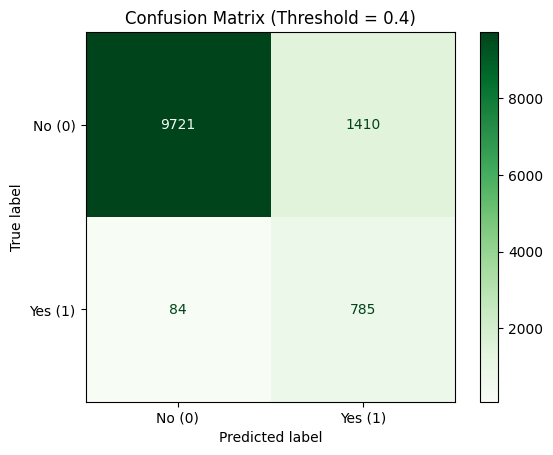

In [ ]:
## Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

threshold = 0.4
y_pred_adjusted = (y_val_prob >= threshold).astype(int)

print(f"\nClassification Report (Threshold = {threshold}):")
print(classification_report(y_val, y_pred_adjusted, target_names=["Negative", "Positive"]))

cm_adjusted = confusion_matrix(y_val, y_pred_adjusted)
disp_adjusted = ConfusionMatrixDisplay(confusion_matrix=cm_adjusted, display_labels=['No (0)','Yes (1)'])
disp_adjusted.plot(cmap='Greens')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.show()

<a name="d) Feature Engineering"></a>
##### <b>5.d Feature Engineering</b>  

In [ ]:
import helper_module
importlib.reload(helper_module)

# Dataset split
df_train_init, df_val = train_test_split(df, test_size=0.3, stratify=df['y'], random_state=42)
df_train, df_test = train_test_split(df_train_init, test_size=0.2, stratify=df_train_init['y'], random_state=42)

# Engineer features on data
X_train_init_nf, y_train_init_nf, encoder, _ = helper_module.engineer_features(df_train_init, encoder=None, fit_encoder=True)

X_val_nf, y_val_nf, _, _ = helper_module.engineer_features(df_val, encoder=encoder, fit_encoder=False)
X_test_nf, y_test_nf, _, _ = helper_module.engineer_features(df_test, encoder=encoder, fit_encoder=False)

<p style="font-size:14px; line-height:1.5; margin-top:0px; margin-bottom:4px;"><b>Running XGBoost including new Features</b>

In [ ]:
metrics_nf = []
# Use only XGBoost
model = XGBClassifier(scale_pos_weight=12,
                            random_state=42,
                            n_estimators=2000,
                            max_depth=5,
                            learning_rate=0.01,
                            use_label_encoder=False,
                            eval_metric='logloss',
                            gamma=0.1,  # Added regularization
                            subsample=0.8,  # Use 80% of data for each tree
                            colsample_bytree=0.8  # Use 80% of features
                            )

model.fit(X_train_init_nf, y_train_init_nf,
          eval_set=[(X_train_init_nf, y_train_init_nf),(X_val_nf, y_val_nf)],  #This parameter doesn't add any significant improvement to the model
          verbose=False)

    # Fit on training data
y_train_pred = model.predict(X_train_init_nf)
y_train_prob = model.predict_proba(X_train_init_nf)[:, 1]

y_val_pred = model.predict(X_val_nf)
y_val_prob = model.predict_proba(X_val_nf)[:, 1]

# Accuracy
train_accuracy = accuracy_score(y_train_init_nf, y_train_pred)
val_accuracy = accuracy_score(y_val_nf, y_val_pred)

train_recall = recall_score(y_train_init_nf, y_train_pred)
val_recall = recall_score(y_val_nf, y_val_pred)

train_precision = precision_score(y_train_init_nf, y_train_pred)
val_precision = precision_score(y_val_nf, y_val_pred)

train_f1 = f1_score(y_train_init_nf, y_train_pred)
val_f1 = f1_score(y_val_nf, y_val_pred)

train_auc = roc_auc_score(y_train_init_nf, y_train_prob)
val_auc = roc_auc_score(y_val_nf, y_val_prob)

# Store metrics
metrics_nf.append({
'Model': 'XGBoost',
'Train Accuracy': train_accuracy,
'Val Accuracy': val_accuracy,
'Train Precision': train_precision,
'Val Precision': val_precision,
'Train Recall': train_recall,
'Val Recall': val_recall,
'Train F1 Score': train_f1,
'Val F1 Score': val_f1,
'Train AUC': train_auc,
'Val AUC': val_auc
})

metrics_nf_df = pd.DataFrame(metrics_nf)

In [ ]:
# Getting metrics of the model
metrics_nf_df_sorted = metrics_nf_df.sort_values(by='Val Recall', ascending=False)
print("\ Metrics:")
metrics_nf_df_sorted.head()

\ Metrics:


,Model,Train Accuracy,Val Accuracy,Train Precision,Val Precision,Train Recall,Val Recall,Train F1 Score,Val F1 Score,Train AUC,Val AUC
0,XGBoost,0.894357,0.875417,0.403202,0.351236,0.956586,0.850403,0.567291,0.497141,0.970411,0.931286


<p style="font-size:14px; line-height:1.5; margin-top:0px; margin-bottom:4px;"><b>Observations: </b>The model including new features did not improved</p>

<p style="font-size:14px; line-height:1.5; margin-top:0px; margin-bottom:4px;"><b>Getting a table with features and their correspondent importance </b>

In [ ]:
import helper_module
importlib.reload(helper_module)

# Dataset split
df_train_init, df_val = train_test_split(df, test_size=0.3, stratify=df['y'], random_state=42)
df_train, df_test = train_test_split(df_train_init, test_size=0.2, stratify=df_train_init['y'], random_state=42)

# Engineer features on data
X_train_init_nf, y_train_init_nf, encoder, feature_names = helper_module.engineer_features(df_train_init, encoder=None, fit_encoder=True)
X_val_nf, y_val_nf, _, _ = helper_module.engineer_features(df_val, encoder=encoder, fit_encoder=False)
X_test_nf, y_test_nf, _, _ = helper_module.engineer_features(df_test, encoder=encoder, fit_encoder=False)

xgb_imp = model.feature_importances_
feature_names = model.get_booster().feature_names

# Create a DataFrame for feature importance
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_imp
}).sort_values(by='Importance', ascending=False)
feature_importances.head(50)

,Feature,Importance
61,duration_min,0.118229
27,contact_unknown,0.061165
38,loan_type_No loan,0.055106
34,seasonal_effect_Summer,0.043422
21,housing_no,0.042057
22,housing_yes,0.038990
33,seasonal_effect_Spring,0.036685
32,seasonal_effect_Fall,0.035678
40,day_of_month_effect_End,0.028977
31,age_group_64+,0.027393


<a name="Model Diagnostic and Evaluation"></a>
#### <b>6. Model Diagnostic and Evaluation</b>

<a name="a) Plotting Loss Curves - XGBoost Model"></a>
##### <b>6.a Plotting Loss Curves - XGBoost Model</b>

In [ ]:
import helper_module
importlib.reload(helper_module)

# Prepare data (no transforms yet)
X, y, column_info = helper_module.preprocessing_data(df)

# Split into train, val, test
X_train_raw, X_val, y_train_init, y_val = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
X_train_final, X_test, y_train_final, y_test = train_test_split(X_train_raw, y_train_init, stratify=y_train_init, test_size=0.2, random_state=42)

# ColumnTransformer (fit on train only)
preprocessor = ColumnTransformer(transformers=[
    ('num', 'passthrough', column_info['numerical']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), column_info['categorical'])
])

#Fit transformer only on training data
preprocessor.fit(X_train_raw)

# Transform splits
X_train_init = preprocessor.transform(X_train_raw)
X_val = preprocessor.transform(X_val)
x_test = preprocessor.transform(X_test)

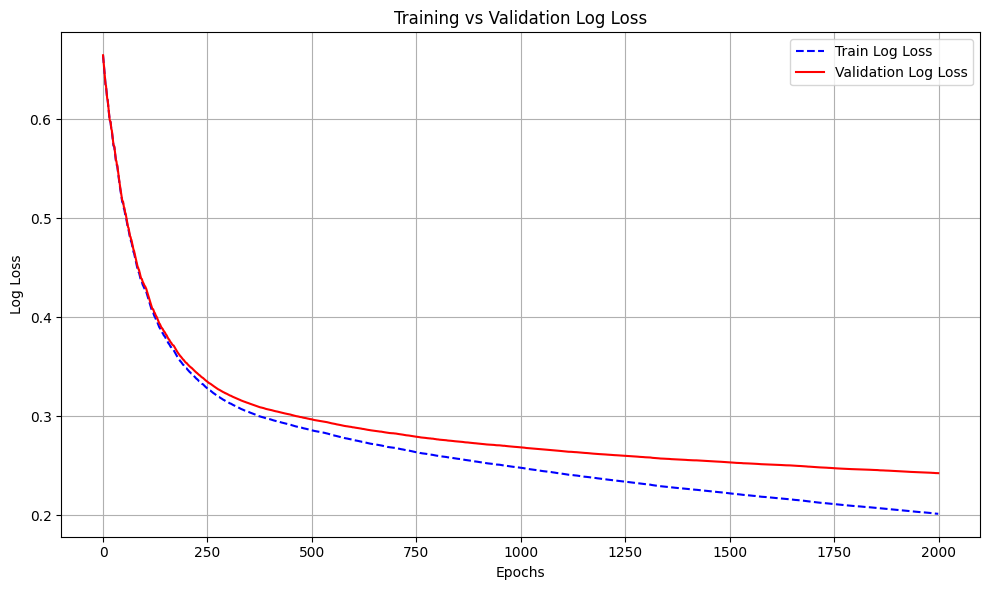


Metrics:
Recall Score: 0.8688147295742232
F1 Score: 0.5379408621303883
Accuracy Score: 0.8919166666666667
Precision Score: 0.3895768833849329
AUC Score: 0.9435734431225414


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve


# Use only XGBoost
final_model = XGBClassifier(scale_pos_weight=12,
                            random_state=42,
                            n_estimators=2000,
                            max_depth=5,
                            learning_rate=0.01,
                            use_label_encoder=False,
                            eval_metric='logloss',
                            gamma=0.1,  # Added regularization
                            subsample=0.8,  # Use 80% of data for each tree
                            colsample_bytree=0.8  # Use 80% of features
                            )

final_model.fit(X_train_init, y_train_init,
          eval_set=[(X_train_init, y_train_init), (X_val, y_val)],
          verbose=False)



# Plot log loss
evals_result = final_model.evals_result()
train_logloss = evals_result['validation_0']['logloss']
val_logloss   = evals_result['validation_1']['logloss']

plt.figure(figsize=(10, 6))
plt.plot(train_logloss, label='Train Log Loss', linestyle='--', color='blue')
plt.plot(val_logloss, label='Validation Log Loss', linestyle='-', color='red')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Training vs Validation Log Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate model
y_pred = final_model.predict(X_val)
y_proba = final_model.predict_proba(X_val)[:, 1]


print(f"\nMetrics:")
print("Recall Score:", recall_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))
print("Accuracy Score:", accuracy_score(y_val, y_pred))
print("Precision Score:", precision_score(y_val, y_pred))
print("AUC Score:", roc_auc_score(y_val, y_proba))


<p style="font-size:14px; line-height:1.5; margin-top:0px; margin-bottom:4px;"><b>Observations: </b>TAs Validation and Training curves are moving very close over epochs, this model seems to be a good choice.</p>

<a name="b) Classification Report and Confusion Matrix"></a>
##### <b>6.b. Classification Report and Confusion Matrix</b>                      


Classification Report:
              precision    recall  f1-score   support

    Negative       0.99      0.89      0.94     11131
    Positive       0.39      0.87      0.54       869

    accuracy                           0.89     12000
   macro avg       0.69      0.88      0.74     12000
weighted avg       0.95      0.89      0.91     12000



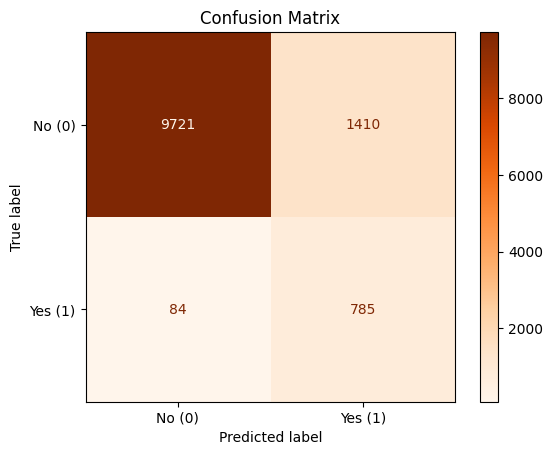

In [ ]:
## Model evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Adjusted threshold
threshold = 0.4
y_pred_adj = (y_proba >= threshold).astype(int)

# Classification report
print(f"\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=["Negative", "Positive"]))

## Confusion matrix
cm_adjusted = confusion_matrix(y_val, y_pred_adj)
disp_adjusted = ConfusionMatrixDisplay(confusion_matrix=cm_adjusted, display_labels=['No (0)','Yes (1)'])
disp_adjusted.plot(cmap='Oranges')
plt.title(f'Confusion Matrix')
plt.show()

 <a id="sec-2"></a>
<h4 style="font-size:10px; font-weight:bold; margin-bottom:4px;"><b>Confusion Matrix Interpretation</b></h4>  
<br>

<table border="1" style="border-collapse: collapse; text-align: center;">
  <tr>
    <th></th>
    <th>Predicted: 0 (No)</th>
    <th>Predicted: 1 (Yes)</th>
  </tr>
  <tr>
    <th>Actual: 0 (No)</th>
    <td>TN</td>
    <td>FP</td>
  </tr>
  <tr>
    <th>Actual: 1 (Yes)</th>
    <td>FN</td>
    <td>TP</td>
  </tr>
</table>

<br>
<p style="font-size:12px; line-height:1.5; margin-top:0px; margin-bottom:4px;">
Classes: 0 (No) and 1 (Yes) Subscription <br>
<b>TN (True Negative)</b>: Correctly predicted No subscriptions <br>
<b>FP (False Positive)</b>: Incorrectly predicted Subscription vs. actual No subscription (Waste offer)<br>
<b>FN (False Negative)</b>: Incorrectly predicted No subscription vs. actual Subscription (Cost opportunity)<br>
<b>TP (True Positive)</b>: Correctly predicted Subscriptions <br>
FN might represent a higher cost for the company, because they will be missing a subscription, potential revenue.</p>
<br>

## The model is overfitted:

In [ ]:
import helper_module
importlib.reload(helper_module)

# Prepare data (no transforms yet)
X, y, column_info = helper_module.preprocessing_data(df)

# Split into train, val, test
X_train_raw, X_val, y_train_init, y_val = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
X_train_final, X_test, y_train_final, y_test = train_test_split(X_train_raw, y_train_init, stratify=y_train_init, test_size=0.2, random_state=42)

# ColumnTransformer (fit on train only)
preprocessor = ColumnTransformer(transformers=[
    ('num', 'passthrough', column_info['numerical']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), column_info['categorical'])
])

#Fit transformer only on training data
preprocessor.fit(X_train_raw)

# Transform splits
X_train_init = preprocessor.transform(X_train_raw)
X_val = preprocessor.transform(X_val)
x_test = preprocessor.transform(X_test)

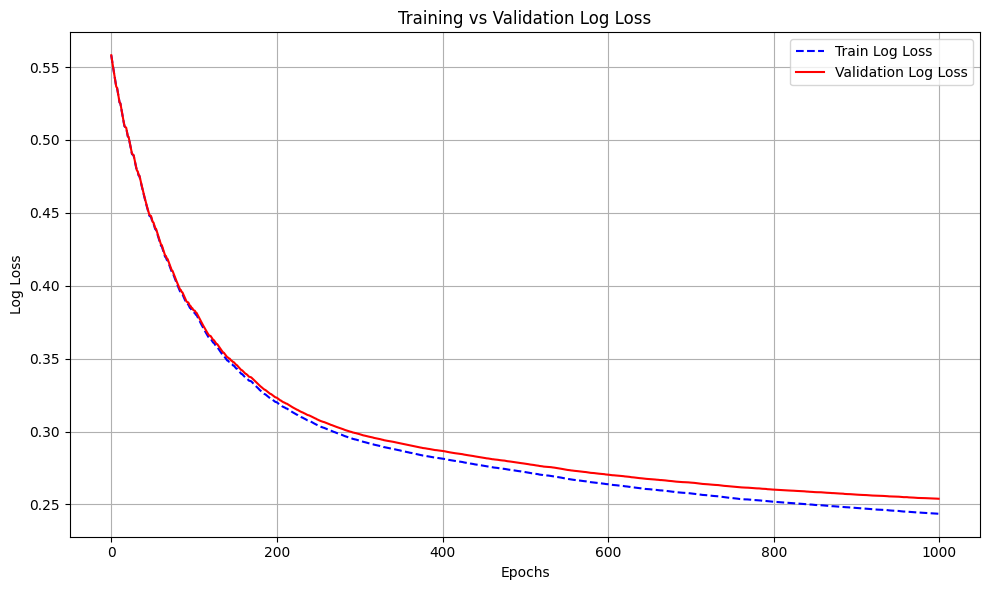

,Model,Train Accuracy,Val Accuracy,Train Precision,Val Precision,Train Recall,Val Recall,Train F1 Score,Val F1 Score,Train AUC,Val AUC
0,XGBoost,0.894357,0.875417,0.403202,0.351236,0.956586,0.850403,0.567291,0.497141,0.970411,0.931286


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight

metrics_f = []
# Use only XGBoost
final_model = XGBClassifier(scale_pos_weight=9,
                            random_state=42,
                            n_estimators=1000,
                            max_depth=4,
                            learning_rate=0.01,
                            use_label_encoder=False,
                            eval_metric='logloss',
                            gamma=0.1,  # Added regularization
                            subsample=0.8,  # Use 80% of data for each tree
                            colsample_bytree=0.8,  # Use 80% of features
                            early_stopping_rounds=50
                            )

final_model.fit(X_train_init, y_train_init,
          eval_set=[(X_train_init, y_train_init), (X_val, y_val)],
          verbose=False)



# Plot log loss
evals_result = final_model.evals_result()
train_logloss = evals_result['validation_0']['logloss']
val_logloss   = evals_result['validation_1']['logloss']

plt.figure(figsize=(10, 6))
plt.plot(train_logloss, label='Train Log Loss', linestyle='--', color='blue')
plt.plot(val_logloss, label='Validation Log Loss', linestyle='-', color='red')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Training vs Validation Log Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate model
y_train_pred = final_model.predict(X_train_init)
y_train_prob = final_model.predict_proba(X_train_init)[:, 1]

y_val_pred = final_model.predict(X_val)
y_val_prob = final_model.predict_proba(X_val)[:, 1]

# Calculating metrics
train_accuracy = accuracy_score(y_train_init, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

train_recall = recall_score(y_train_init, y_train_pred)
val_recall = recall_score(y_val, y_val_pred)

train_precision = precision_score(y_train_init, y_train_pred)
val_precision = precision_score(y_val, y_val_pred)

train_f1 = f1_score(y_train_init, y_train_pred)
val_f1 = f1_score(y_val, y_val_pred)

train_auc = roc_auc_score(y_train_init, y_train_prob)
val_auc = roc_auc_score(y_val, y_val_prob)

metrics_f.append({
'Model': 'XGBoost',
'Train Accuracy': train_accuracy,
'Val Accuracy': val_accuracy,
'Train Precision': train_precision,
'Val Precision': val_precision,
'Train Recall': train_recall,
'Val Recall': val_recall,
'Train F1 Score': train_f1,
'Val F1 Score': val_f1,
'Train AUC': train_auc,
'Val AUC': val_auc
})

metrics_f = pd.DataFrame(metrics_f)
metrics_f

<a name="c) Diagnostic Charts: y-True, y-Predicted, vs. X variables"></a>
##### <b>6.c. Diagnostic Charts: y-True, y-Predicted, vs. X variables</b>

In [ ]:
# Prepare data (no transforms yet)
X, y, column_info = helper_module.preprocessing_data(df)

# Split into train, val, test
X_train_raw, X_val, y_train_init, y_val = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train_raw, y_train_init, stratify=y_train_init, test_size=0.2, random_state=42)

# ColumnTransformer (fit on train only)
preprocessor = ColumnTransformer(transformers=[
    ('num', 'passthrough', column_info['numerical']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), column_info['categorical'])
])

#Fit transformer only on training data
preprocessor.fit(X_train)

# Transform splits
X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)

In [ ]:
final_model = XGBClassifier(scale_pos_weight=9,
                            random_state=42,
                            n_estimators=1000,
                            max_depth=4,
                            learning_rate=0.01,
                            use_label_encoder=False,
                            eval_metric='logloss',
                            gamma=0.1,  # Added regularization
                            subsample=0.8,  # Use 80% of data for each tree
                            colsample_bytree=0.8,  # Use 80% of features
                            early_stopping_rounds=50
                            )

final_model.fit(X_train_proc, y_train,
          eval_set=[(X_train_proc, y_train), (X_test_proc, y_test)],
          verbose=False)


# --- Predict on Test Set ---
y_test_probs = final_model.predict_proba(X_test_proc)[:, 1]

threshold = 0.6     # --- Adjust Threshold ---
y_test_pred_adjusted = (y_test_probs >= threshold).astype(int)
# y_test_pred_adjusted = final_model.predict(X_test_proc)

# --- Restore Original Labels (if encoded) ---
actual_labels = y_test
pred_labels = y_test_pred_adjusted

# --- Build Results DataFrame ---     #### Review labesl of the y_true (make sure this is correct)
results_df = X_test.copy()
results_df['y_true'] = y_test
results_df['y_predicted'] = y_test_pred_adjusted
results_df['predicted_prob_yes'] = y_test_probs

results_df = results_df.sort_values(by='predicted_prob_yes', ascending=False, ignore_index=True)
results_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,duration_min,y_true,y_predicted,predicted_prob_yes
0,67.0,retired,married,tertiary,no,1341.0,no,no,cellular,13,feb,1,9.5,1,1,0.981913
1,28.0,technician,single,tertiary,no,386.0,no,no,cellular,25,may,1,9.5,1,1,0.978880
2,28.0,technician,single,tertiary,no,3216.5,no,no,cellular,2,jun,2,9.5,1,1,0.974888
3,30.0,admin,single,tertiary,no,305.0,no,no,cellular,30,apr,1,9.5,1,1,0.972779
4,49.0,technician,divorced,secondary,no,972.0,no,no,cellular,25,may,2,9.5,0,1,0.967583


In [ ]:
# --- Saving results to analyze true vs. prediction ---
results_df.to_csv("/content/drive/MyDrive/Colab Notebooks/Proj2/model_predictions.csv", index=False)


Classification Report:
              precision    recall  f1-score   support

    Negative       0.99      0.91      0.95      5195
    Positive       0.42      0.84      0.56       405

    accuracy                           0.91      5600
   macro avg       0.70      0.88      0.75      5600
weighted avg       0.95      0.91      0.92      5600



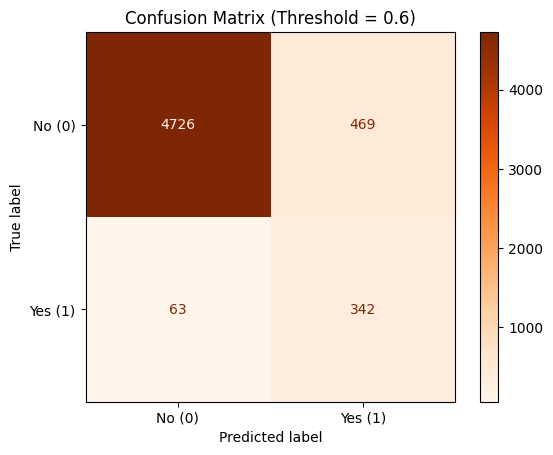

In [ ]:
# Adjusted threshold
y_test_probs = final_model.predict_proba(X_test_proc)[:, 1]
threshold = 0.6
y_pred_adjusted = (y_test_probs >= threshold).astype(int)
# y_pred_adjusted = final_model.predict(X_test_proc)

# Classification report
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_adjusted, target_names=["Negative", "Positive"]))

## Confusion matrix
cm_adjusted = confusion_matrix(y_test, y_pred_adjusted)
disp_adjusted = ConfusionMatrixDisplay(confusion_matrix=cm_adjusted, display_labels=['No (0)','Yes (1)'])
disp_adjusted.plot(cmap='Oranges')
plt.title(f'Confusion Matrix')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.show()

In [ ]:
### Updatd
def plot_x_vs_y_comparison(results_df, X_cols, max_bins=10, n_cols=3):
    '''
    Visualizes the relationship between each column in X_cols and the target variable y,
    comparing both y_true and y_pred averages. Categorical features use bar + line plots,
    numerical features use histograms + average lines.
    '''

    # Identify categorical and numerical columns
    cat_cols = results_df[X_cols].select_dtypes(include=['object', 'category']).columns
    num_cols = results_df[X_cols].select_dtypes(include=['int64', 'float64']).columns
    ordered_cols = list(cat_cols) + list(num_cols)

    n_rows = (len(ordered_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4), dpi=150)
    axes = axes.flatten()

    for idx, col in enumerate(ordered_cols):
        ax = axes[idx]

        if col in cat_cols:
            counts = results_df[col].value_counts()
            true_avg = results_df.groupby(col)['y_true'].mean().reindex(counts.index).fillna(0)
            pred_avg = results_df.groupby(col)['y_predicted'].mean().reindex(counts.index).fillna(0)

            counts.plot(kind='bar', ax=ax, color='lightgray', alpha=0.7)
            ax.set_ylabel('Count')
            ax.set_xlabel(col)

            ax2 = ax.twinx()
            true_avg.plot(marker='o', color='blue', ax=ax2, label='y_true')
            pred_avg.plot(marker='x', color='red', ax=ax2, label='y_predicted')
            ax2.set_ylim(0, 1)
            ax2.set_ylabel('Average')
            ax2.legend(loc='upper right')

            ax.set_title(f'{col}: True vs Predicted Averages')

        else:
            bins = np.linspace(results_df[col].min(), results_df[col].max(), max_bins + 1)
            results_df['binned'] = pd.cut(results_df[col], bins)
            bin_centers = bins[:-1] + np.diff(bins) / 2

            true_avg = results_df.groupby('binned')['y_true'].mean()
            pred_avg = results_df.groupby('binned')['y_predicted'].mean()

            sns.histplot(results_df[col], bins=bins, ax=ax, color='skyblue', stat='count', alpha=0.6)
            ax.set_ylabel('Frequency')
            ax.set_xlabel(col)

            ax2 = ax.twinx()
            ax2.plot(bin_centers, true_avg.values, marker='o', label='y_true', color='blue')
            ax2.plot(bin_centers, pred_avg.values, marker='x', label='y_predicted', color='red')
            ax2.set_ylim(0, 1)
            ax2.set_ylabel('Average')
            ax2.legend(loc='upper right')

            ax.set_title(f'{col}: True vs Predicted Averages')

        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', labelsize=8)
        ax2.tick_params(axis='y', labelsize=8)

    for j in range(len(ordered_cols), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(pad=3.0)

    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    encoded = base64.b64encode(buf.read()).decode('utf-8')
    buf.close()

    display(HTML(f'<img src="data:image/png;base64,{encoded}" width="1400"/>'))
    plt.close(fig)


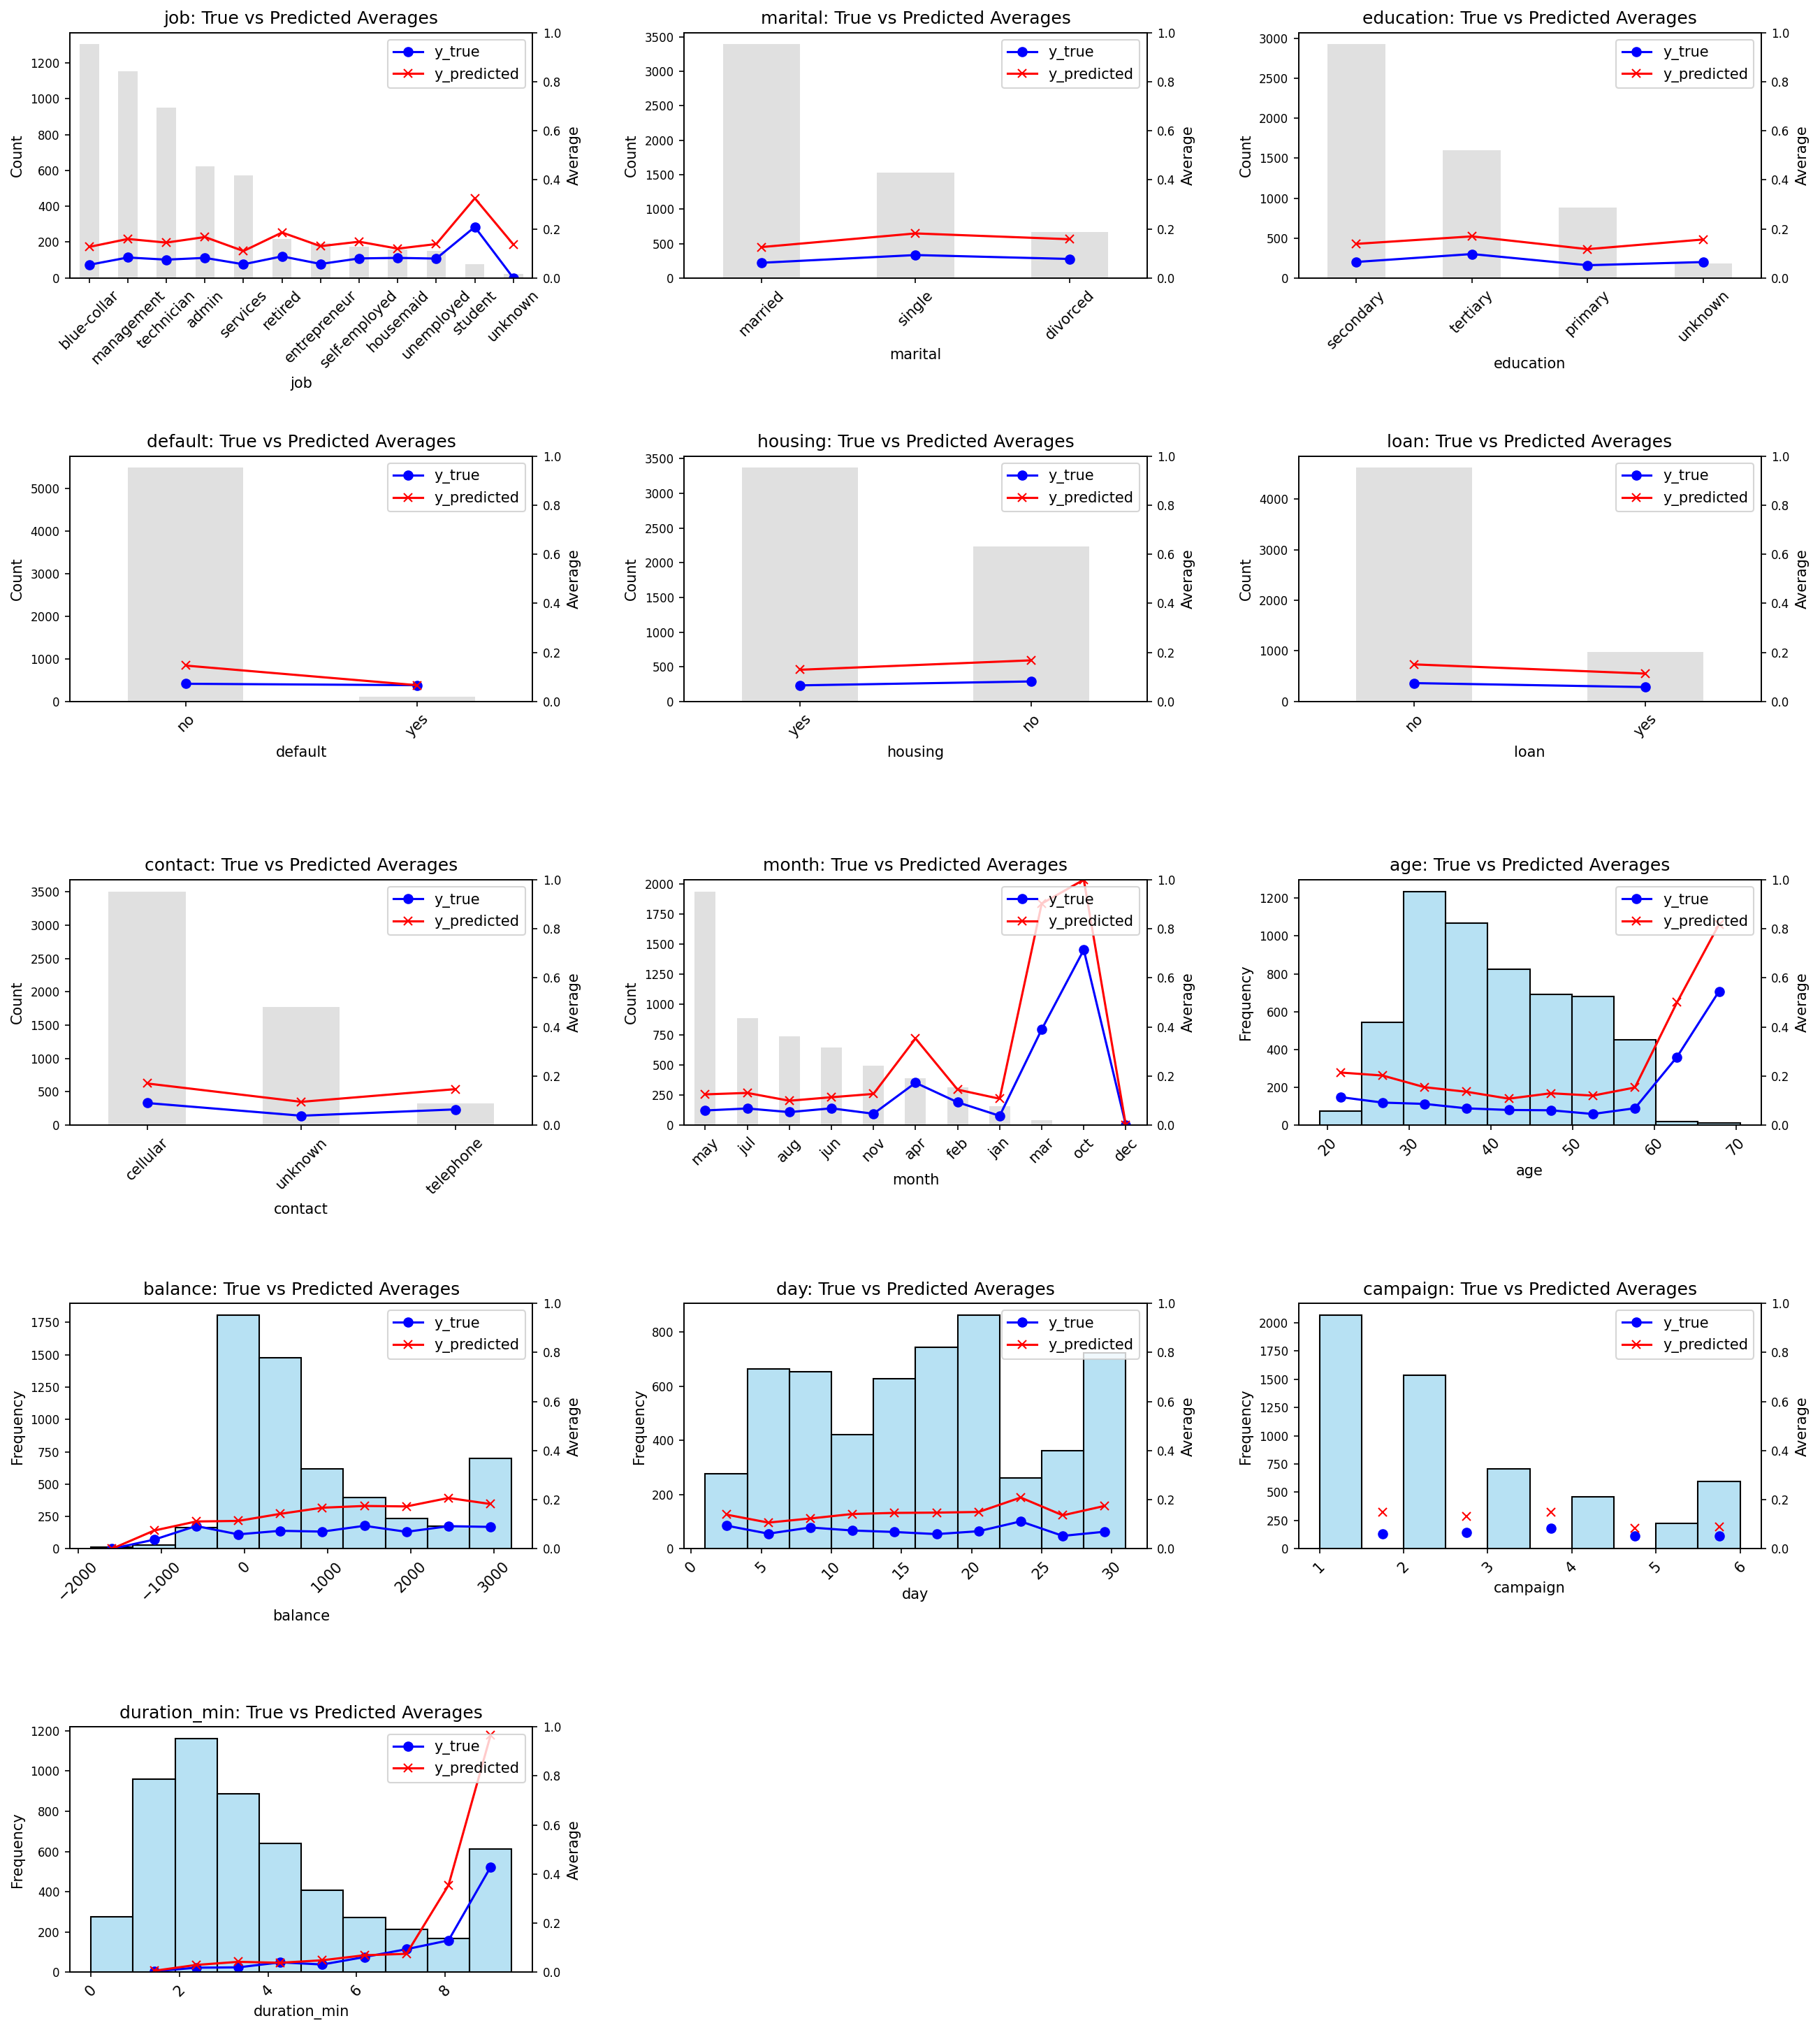

In [ ]:
###
# plot_x_vs_y_comparison(df, X.columns.tolist(), y_true, y_predicted)
X_cols = [col for col in results_df.columns if col not in ['y_true', 'y_predicted']]

plot_x_vs_y_comparison(results_df, X_cols)

#### Observations:
The model is consistently overpredict subcriptions likehood across several features. The reason of this, maybe rooted in the high value set up to the scale_pos_weight parameter, which was intentionally defined that way to compensated for class imbalance.

<a name="Saving Predicted Values"></a>
#### <b>7. Saving Predicted Values</b>

In [ ]:
# Save the DataFrame to a CSV file
results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Proj2/subscription_predictions.csv') # index=False prevents writing the DataFrame index as a column
print("✅ File saved to your current working directory.")

✅ File saved to your current working directory.


<a name="Analysis: Customer Segmentation"></a>
####<b>8. Analysis: Customer Segmentation</b>

In [ ]:

# Sort by prediction confidence and pick top customers
top_customers = results_df.sort_values(by='predicted_prob_yes', ascending=False).head(20).reset_index(drop=True)

# Reordering columns
cols = ['predicted_prob_yes', 'y_predicted', 'y_true'] + [col for col in X_test.columns]
top_customers = top_customers[cols]

# Display result
print("\n Top 30 Customers with Highest Subscription Probability:")
top_customers


 Top 30 Customers with Highest Subscription Probability:


,predicted_prob_yes,y_predicted,y_true,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,duration_min
0,0.981913,1,1,67.0,retired,married,tertiary,no,1341.0,no,no,cellular,13,feb,1,9.5
1,0.978880,1,1,28.0,technician,single,tertiary,no,386.0,no,no,cellular,25,may,1,9.5
2,0.974888,1,1,28.0,technician,single,tertiary,no,3216.5,no,no,cellular,2,jun,2,9.5
3,0.972779,1,1,30.0,admin,single,tertiary,no,305.0,no,no,cellular,30,apr,1,9.5
4,0.967583,1,0,49.0,technician,divorced,secondary,no,972.0,no,no,cellular,25,may,2,9.5
5,0.967405,1,1,38.0,unemployed,single,secondary,no,804.0,no,no,cellular,1,jun,1,9.5
6,0.965096,1,1,58.0,technician,married,secondary,no,3216.5,no,no,cellular,26,may,1,9.5
7,0.961386,1,0,45.0,entrepreneur,married,tertiary,no,98.0,no,no,cellular,1,jun,2,9.5
8,0.957253,1,1,35.0,admin,married,tertiary,no,286.0,no,no,cellular,30,apr,2,9.5
9,0.955225,1,1,27.0,management,single,tertiary,no,831.0,no,no,cellular,30,mar,2,9.5


<a name="Final Notes"></a>
#### <b> Final Notes</b>


*   The <b>final XGBoost model</b> achieved a Recall of 88%, which is good for detecting 'yes' labels.
*   Classification (y-True vs. y-Predicted) performed relatevely similar across X variables. So, the model is not only performing well at general level, but also at feature level.

<a id="sec-2"></a>
<h4 style="font-size:18px; font-weight:bold; margin-bottom:4px;">Next Steps</h4>                                                                                 
<p style="font-size:14px; line-height:1.5; margin-top:0px; margin-bottom:4px;">Save model, encoder, test data, and threshold for further analysis.</p>

In [ ]:
from joblib import dump
import pandas as pd

# Save model pipeline
dump(final_model, '/content/drive/MyDrive/Colab Notebooks/Proj2/final_model_GXboost.joblib')

# Save test data
X_test.to_csv('/content/drive/MyDrive/Colab Notebooks/Proj2/X_test.csv', index=False)
y_test.to_csv('/content/drive/MyDrive/Colab Notebooks/Proj2/y_test.csv', index=False)

# Save threshold as a plain text file
# with open('/content/drive/MyDrive/Colab Noteboos/Proj2/threshold.txt', 'w') as f:
#     f.write(str(threshold))